# **Machine Vision Practical Project**

*Nankai University*

 ***Artificial Intelligence: Algorithms and Applications***





**Authors:**

*   ***Johnny Agosto***
*   ***Chiara Malizia***



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## VERSION INFORMATION ##

import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
## MACHINE GPU INFORMATION ##

!nvidia-smi

Wed Jul 21 19:19:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## IMPORTS ##

from tensorflow.keras.datasets import cifar10
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import os 
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.image import ssim, psnr

from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, MaxPooling2D, Layer, Conv2D, Conv2DTranspose, concatenate)
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import typing

from datetime import datetime
import pandas as pd
now = datetime.now()

In [2]:
## PREPARE DATASET ##

def create_dataset(random_seed):
    random.seed(random_seed)

    #Download CIFAR-10 Dataset
    (x_train, _), (x_test, _) = cifar10.load_data()

    #Blurring Training Set. The sharp images will be our y_pred
    x_train_blurred = []
    for image in x_train:
        #Generate a standard devation sigma (between 0 and 3)
        standard_deviation = random.random() * 3.0
        #Apply the Gaussian filter
        blurred_image = cv2.GaussianBlur(image, ksize = (0,0), sigmaX = standard_deviation, sigmaY = standard_deviation, borderType = cv2.BORDER_DEFAULT)
        x_train_blurred.append(blurred_image)

    x_train_blurred = np.array(x_train_blurred)

    #Blurring Test Set. The sharp images will be our y_pred
    x_test_blurred = []
    for image in x_test:
        #Generate a standard devation sigma (between 0 and 3)
        standard_deviation = random.random() * 3.0
        #Apply the Gaussian filter
        blurred_image = cv2.GaussianBlur(image, ksize = (0,0), sigmaX = standard_deviation, sigmaY = standard_deviation, borderType = cv2.BORDER_DEFAULT)
        x_test_blurred.append(blurred_image)

    x_test_blurred = np.array(x_test_blurred)

    #Image Normalization
    x_train = x_train / 255.0
    x_train_blurred = x_train_blurred / 255.0
    x_test = x_test / 255.0
    x_test_blurred = x_test_blurred / 255.0

    return (x_train, x_train_blurred), (x_test, x_test_blurred)

### GENERATING AN IMAGE WITH DIFFERENT STANDARD DEVIATION


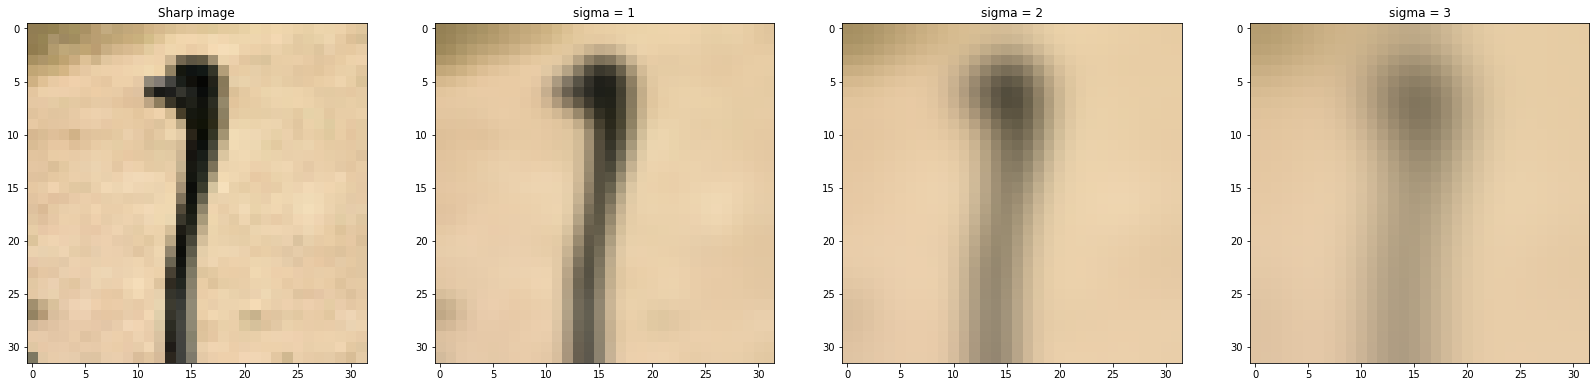

In [18]:
## PLOT AN IMAGE WITH INCREASING STANDARD DEVIATION ##

print("### GENERATING AN IMAGE WITH DIFFERENT STANDARD DEVIATION")

(x_train, _), (x_test, _) = cifar10.load_data()

image = x_train[41]

#Generate a standard devation equal to 1
standard_deviation = 1.0
#Apply the Gaussian filter
blurred_image_1 = cv2.GaussianBlur(image, ksize = (0,0), sigmaX = standard_deviation, sigmaY = standard_deviation, borderType = cv2.BORDER_DEFAULT)

#Generate a standard devation equal to 2
standard_deviation = 2.0
#Apply the Gaussian filter
blurred_image_2 = cv2.GaussianBlur(image, ksize = (0,0), sigmaX = standard_deviation, sigmaY = standard_deviation, borderType = cv2.BORDER_DEFAULT)

#Generate a standard devation equal to 3
standard_deviation = 3.0
#Apply the Gaussian filter
blurred_image_3 = cv2.GaussianBlur(image, ksize = (0,0), sigmaX = standard_deviation, sigmaY = standard_deviation, borderType = cv2.BORDER_DEFAULT)

plt.figure(figsize=(28,7))
plt.subplot(141)
plt.title('Sharp image')
plt.imshow(image)
plt.subplot(142)
plt.title('sigma = 1')
plt.imshow(blurred_image_1)
plt.subplot(143)
plt.title('sigma = 2')
plt.imshow(blurred_image_2)
plt.subplot(144)
plt.title('sigma = 3')
plt.imshow(blurred_image_3)
plt.savefig(os.path.join("/content/drive/MyDrive/Nankai_project/train","std_example.png"))
          

In [ ]:
## DEFINE METRICTS ##

def lad_loss(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

def ssim_metric(trueY, predY):
    return ssim(trueY, predY, max_val=1.)

def psnr_metric(trueY, predY):
    return psnr(trueY, predY, max_val=1.)

In [ ]:
## CREATE MODEL ##

def UConvDown(kernels, filters_num, in_layer, layer_idx, middle = True):
    if middle:
        x = MaxPooling2D(pool_size=2, strides=2, name='pool{0:d}'.format(layer_idx))(in_layer)
    else:
        x = in_layer
        
    n = 0
    for kernel, filter in zip(kernels, filters_num):
        x = Conv2D(filter, kernel_size = kernel, activation = 'relu', padding = 'same', name = 'conv{0:d}_{1:d}'.format(layer_idx, n))(x)
        n += 1
    return x


def UConvUp(kernels, filters_num, in_layer, concat_layer, layer_idx):
    # Upsampling by transposed convolution
    x = Conv2DTranspose(filters_num[0], kernel_size=2, strides=2, activation='relu', padding='same', name='upsamp{0:d}'.format(layer_idx))(in_layer)
    # Concatenation
    x = concatenate([concat_layer, x])

    n = 0
    for kernel, fltr in zip(kernels, filters_num):
        x = Conv2D(fltr,
                   kernel_size=kernel,
                   activation='relu',
                   padding='same',
                   name='conv{0:d}_{1:d}'.format(layer_idx, n))(x)
        n += 1
    return x


def get_UNet20(input_shape):
        # ENCODER
        visible = Input(shape=input_shape)   

        conv1 = UConvDown(kernels=[3, 3],
                          filters_num=[16, 16],
                          in_layer=visible,
                          layer_idx=1,
                          middle=False)  

        conv2 = UConvDown(kernels=[3, 3],
                          filters_num=[32, 32],
                          in_layer=conv1,
                          layer_idx=2)  

        conv3 = UConvDown(kernels=[3, 3],
                          filters_num=[64, 64],
                          in_layer=conv2,
                          layer_idx=3) 

        conv4 = UConvDown(kernels=[3, 3],
                          filters_num=[128, 128],
                          in_layer=conv3,
                          layer_idx=4) 

        # BOTTLENECK
        conv5 = UConvDown(kernels=[3, 3],
                          filters_num=[256, 256],
                          in_layer=conv4,
                          layer_idx=5)

        # DECODER
        conv6 = UConvUp(kernels=[3, 3],
                        filters_num=[128, 128],
                        in_layer=conv5,
                        concat_layer=conv4,
                        layer_idx=6) 

        conv7 = UConvUp(kernels=[3, 3],
                        filters_num=[64, 64],
                        in_layer=conv6,
                        concat_layer=conv3,
                        layer_idx=7)  

        conv8 = UConvUp(kernels=[3, 3],
                        filters_num=[32, 32],
                        in_layer=conv7,
                        concat_layer=conv2,
                        layer_idx=8)  

        conv9 = UConvUp(kernels=[3, 3, 1],
                        filters_num=[16, 16, 3],
                        in_layer=conv8,
                        concat_layer=conv1,
                        layer_idx=9)  

        return Model(inputs=visible, outputs=conv9)

In [ ]:
## CREATE AND SAVE A MODEL ##

input_shape=(32, 32, 3)
filepath = '/content/drive/MyDrive/Nankai_project/prova.json'

model = get_UNet20(input_shape=input_shape)
model_json = model.to_json()
with open(filepath, "w") as json_file:
  json_file.write(model_json)
model.summary()

print(" ")
print("Saved model to: {}".format(filepath))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_0 (Conv2D)                (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 16)   2320        conv1_0[0][0]                    
__________________________________________________________________________________________________
pool2 (MaxPooling2D)            (None, 16, 16, 16)   0           conv1_1[0][0]                    
______________________________________________________________________________________________

### LOADING MODEL ###


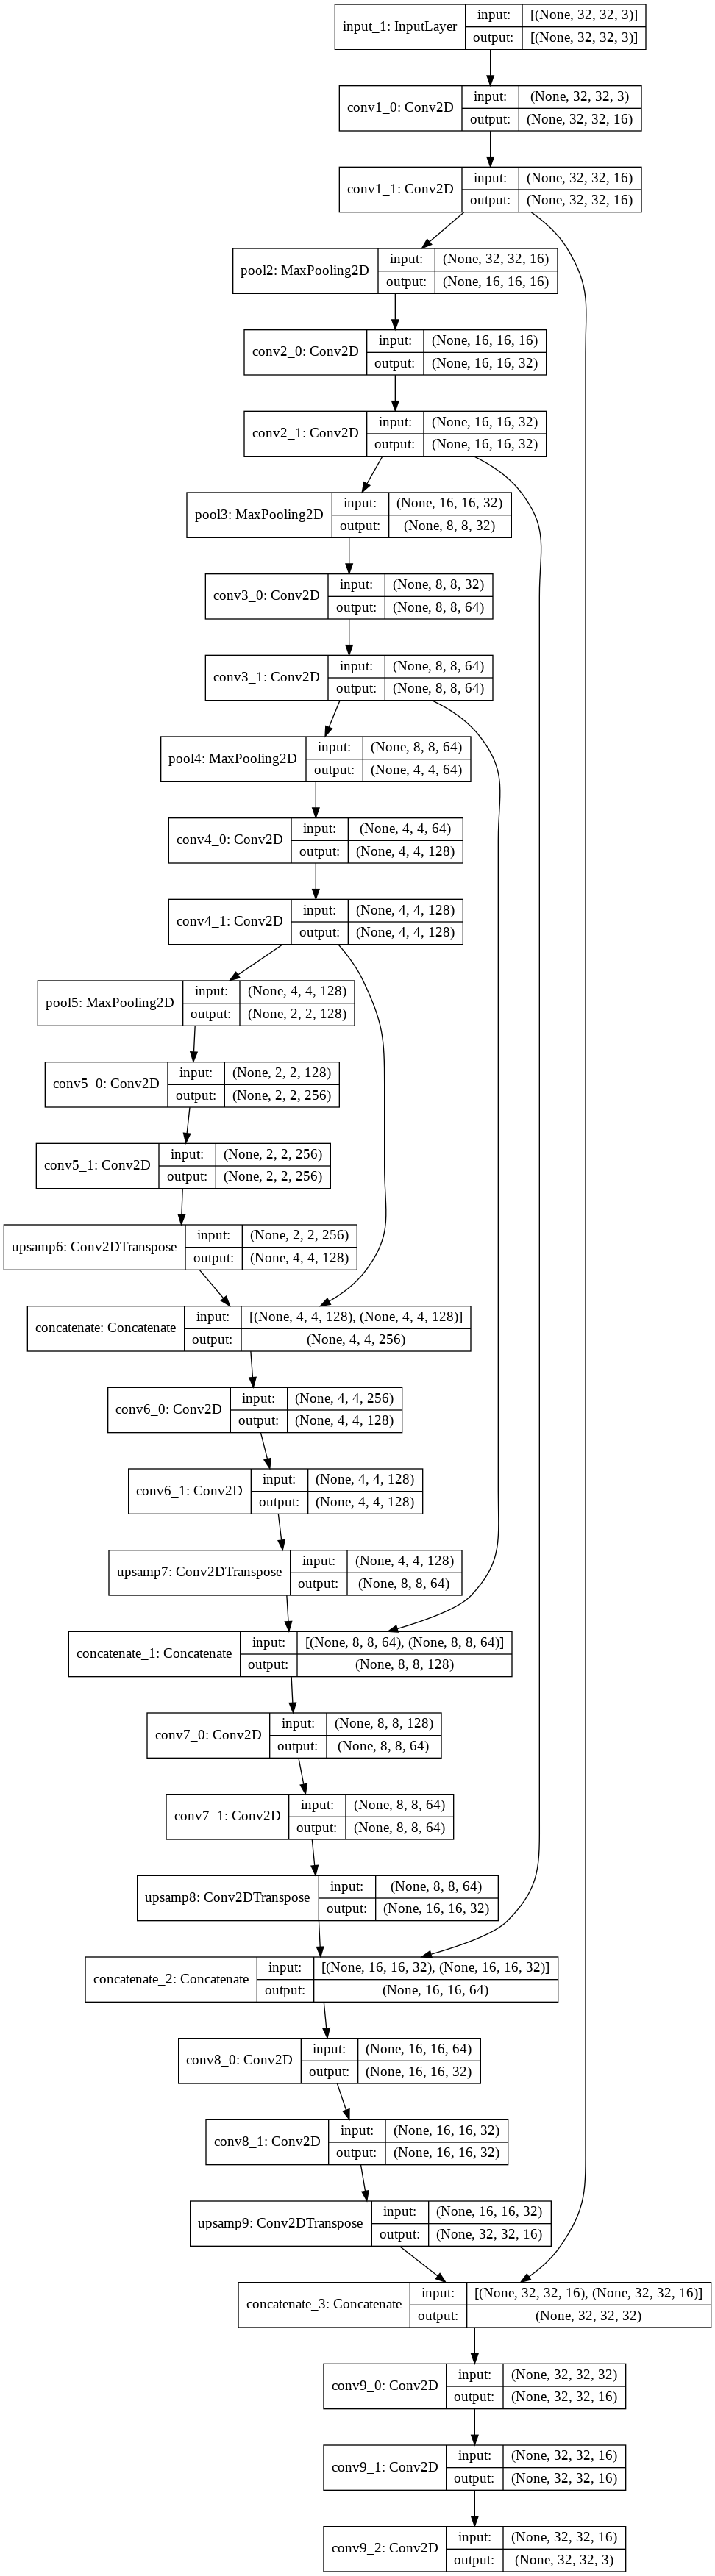

In [ ]:
## PLOT THE MODEL ##

print("### LOADING MODEL ###")
json_file = open('/content/drive/MyDrive/Nankai_project/prova.json')
loaded_model_json = json_file.read()
json_file.close()
model = tensorflow.keras.models.model_from_json(loaded_model_json)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
## COMPILE THE MODEL ##
 
print("### COMPILING MODEL ###")
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate, clipnorm = True)
model.compile(optimizer = optimizer, loss = lad_loss, metrics = [ssim_metric, psnr_metric, 'mse'])

print(" ")
print("### END ###")



### COMPILING MODEL ###
 
### END ###


In [ ]:
## TRAIN ##

seed = 47
batch_size = 32
workers = 1
epochs = 500

save_dir = '/content/drive/MyDrive/Nankai_project/train'

print("### LOADING DATA ###")
(x_train, x_train_blurred), (x_test, x_test_blurred) = create_dataset(random_seed=seed)

print("")
print("### TRAINING MODEL###")
print("")
callback = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True),
            ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, min_lr = 0.00001)]
history = model.fit(x = x_train_blurred, y = x_train, batch_size = batch_size, validation_split = 0.2, epochs= epochs, workers = workers, callbacks = callback )

print("### TRAINING ENDED ###")
print("")



### LOADING DATA ###
170500096/170498071 [==============================] - 3s 0us/step

### TRAINING MODEL###

Epoch 1/500
1250/1250 [==============================] - 57s 20ms/step - loss: 5668.9663 - ssim_metric: 0.7523 - psnr_metric: 23.6211 - mse: 0.0114 - val_loss: 4082.9519 - val_ssim_metric: 0.8305 - val_psnr_metric: 25.7458 - val_mse: 0.0038
Epoch 2/500
1250/1250 [==============================] - 24s 19ms/step - loss: 3873.5889 - ssim_metric: 0.8401 - psnr_metric: 26.2614 - mse: 0.0036 - val_loss: 3670.4856 - val_ssim_metric: 0.8536 - val_psnr_metric: 26.7699 - val_mse: 0.0032
Epoch 3/500
1250/1250 [==============================] - 24s 19ms/step - loss: 3591.7620 - ssim_metric: 0.8575 - psnr_metric: 26.9760 - mse: 0.0032 - val_loss: 3381.5044 - val_ssim_metric: 0.8684 - val_psnr_metric: 27.5120 - val_mse: 0.0029
Epoch 4/500
1250/1250 [==============================] - 23s 18ms/step - loss: 3458.4749 - ssim_metric: 0.8651 - psnr_metric: 27.3688 - mse: 0.0030 - val_loss: 3381.

In [ ]:
## SAVE MODEL AND HISTORY ##

print("### SAVING MODEL ###")
weights_path = os.path.join(save_dir,'weights-{}.h5'.format(now))
model.save_weights(weights_path)
print("Weights saved to: weights-{}.h5 inside the train directory".format(now))

print("")
print("### SAVING HISTORY ###")
df_hist = pd.DataFrame.from_dict(history.history)
history_path = os.path.join(save_dir,'history-{}.csv'.format(now))
df_hist.to_csv(history_path, mode='w', header=True)
print("Weights saved to: history-{}.csv inside the train directory".format(now))
print("")

print("### END ###")

### SAVING MODEL ###
Weights saved to: weights-2021-07-20 17:33:51.616348.h5 inside the train directory

### SAVING HISTORY ###
Weights saved to: history-2021-07-20 17:33:51.616348.csv inside the train directory

### END ###


In [ ]:
## TEST ##

save_dir = '/content/drive/MyDrive/Nankai_project/test'

print("### LOADING MODEL ###")
json_file = open(filepath)
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)

weights = '/content/drive/MyDrive/Nankai_project/train/weights-2021-07-20 17:33:51.616348.h5'
print("### LOADING WEIGHTS ###")
model.load_weights(weights)
    
print("### COMPILING MODEL ###")
opt = tf.keras.optimizers.Adam(learning_rate=0.0, clipnorm = True)
model.compile(optimizer=opt, loss=lad_loss, metrics=[ssim_metric, psnr_metric, 'mse'])


def load_data_test(test_mode, batch_size, workers, model_dir, seed, n_batch = None): 

    if test_mode == 'evaluate':
        print("")
        print("### EVALUATING MODEL###")
        print("")
        history = model.evaluate(x = x_test_blurred , y = x_test, batch_size = batch_size, workers = workers)
        print("### EVALUATION ENDED ###")
        print("")
        print("### SAVING RESULTS ###")
        df_hist = pd.DataFrame(history, index = ['loss', 'ssim', 'psnr', 'mse'], columns = ['Values'])
        df_hist.to_csv(os.path.join(save_dir, 'results-{}.csv'.format(now)), mode = 'w', header = True)
        print("### SAVING ENDED ###")
    
    elif test_mode == 'batch':
        print("")
        print("### CREATING TEST IMAGES ###")
        print("")
        img_dir = os.path.join(save_dir, "TEST_IMGS_{}".format(now))
        if not os.path.isdir(img_dir):
            os.mkdir(img_dir)
        j = 0
        i = 0
        n = 0
        for j in range(n_batch):
            blur_imgs = x_test_blurred[j*batch_size:(j+1)*batch_size]
            sharp_imgs = x_test[j*batch_size:(j+1)*batch_size]
            predicted = model.predict(blur_imgs, workers = workers, batch_size = batch_size)
            for i in range(batch_size):
                plt.figure(figsize=(21,7))
                plt.subplot(131)
                plt.imshow(blur_imgs[i])
                plt.subplot(132)
                plt.imshow(predicted[i])
                plt.subplot(133)
                plt.imshow(sharp_imgs[i])
                plt.savefig(os.path.join(save_dir,"img{}.png".format(n)))
                n+=1
        print("Figures saved to {}".format(save_dir))
        print("")
        print("### END ###")

### LOADING MODEL ###
### LOADING WEIGHTS ###
### COMPILING MODEL ###


In [ ]:
## EVALUATE TEST ##
result = load_data_test(test_mode = 'evaluate' , batch_size = batch_size, workers = workers, model_dir = save_dir, seed = seed)


### EVALUATING MODEL###

313/313 [==============================] - 3s 8ms/step - loss: 2690.5256 - ssim_metric: 0.8970 - psnr_metric: 30.4023 - mse: 0.0021
### EVALUATION ENDED ###

### SAVING RESULTS ###
### SAVING ENDED ###



### CREATING TEST IMAGES ###



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clippi

Figures saved to /content/drive/MyDrive/Nankai_project/test

### END ###


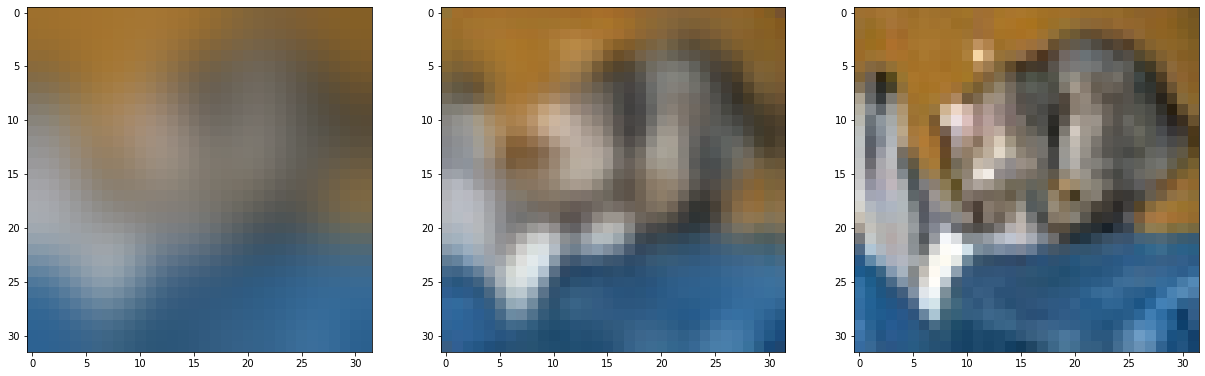

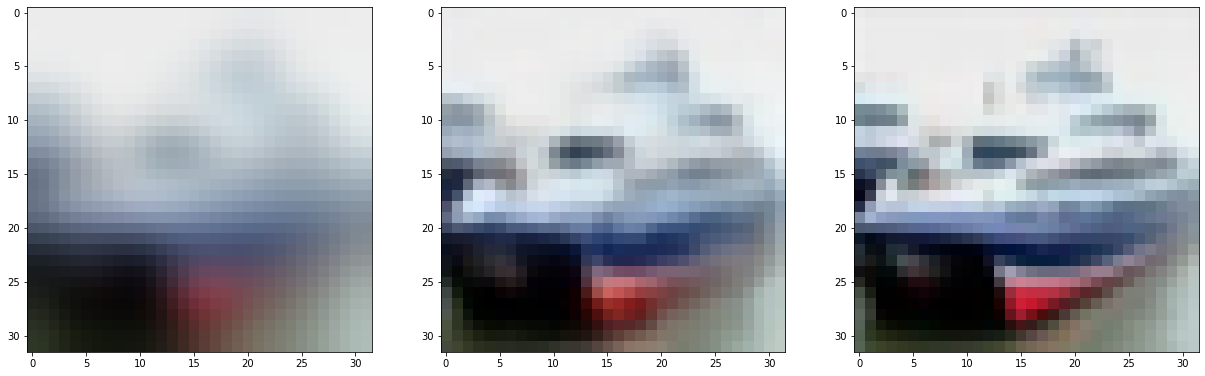

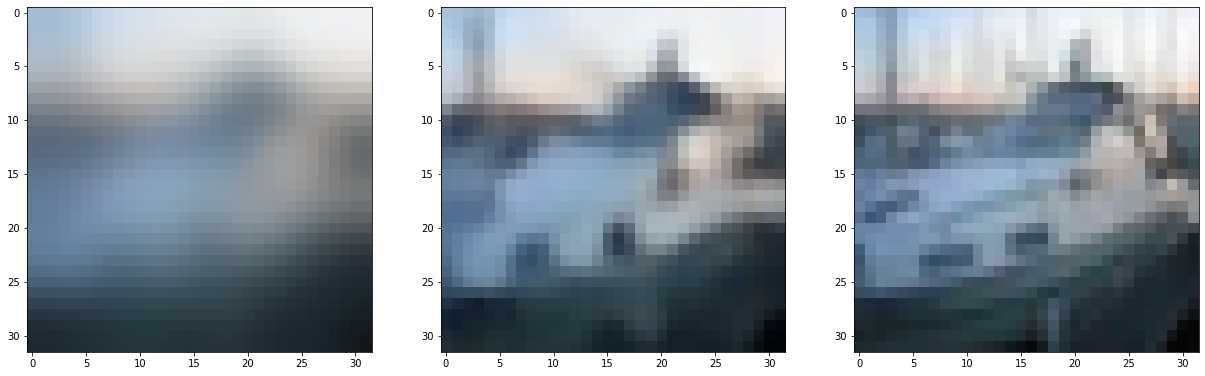

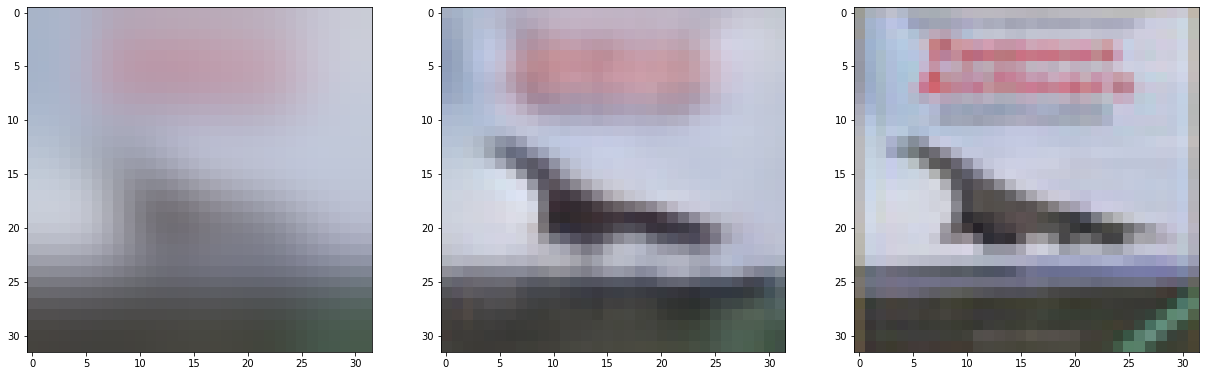

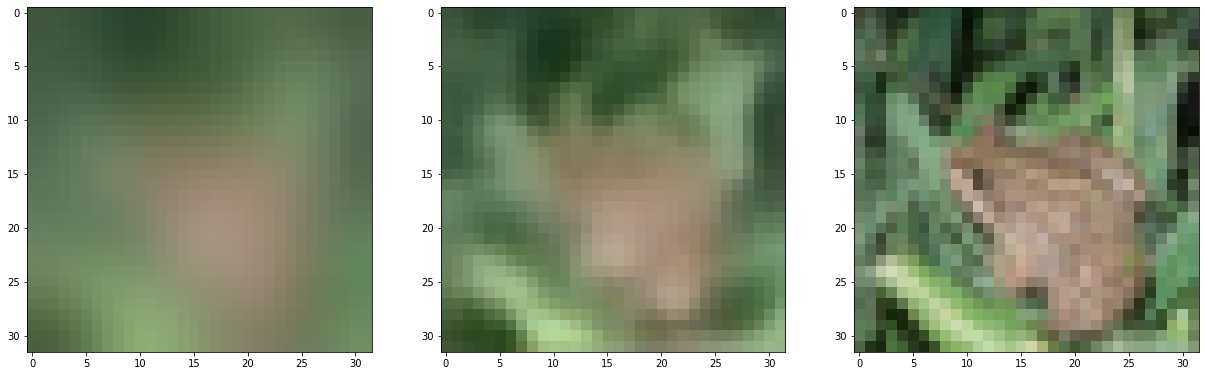

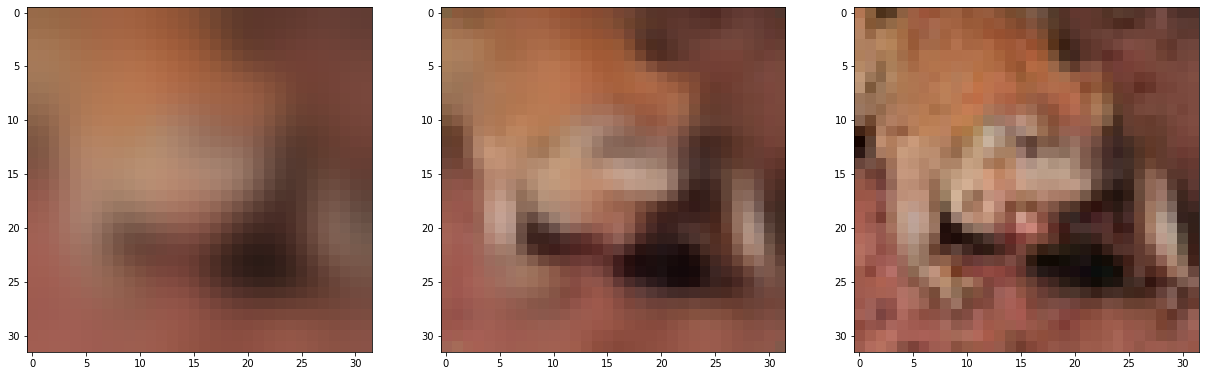

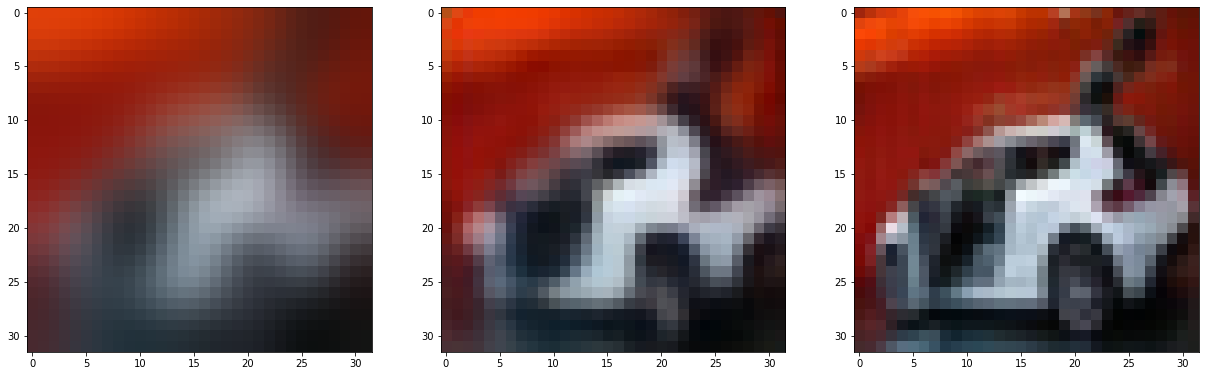

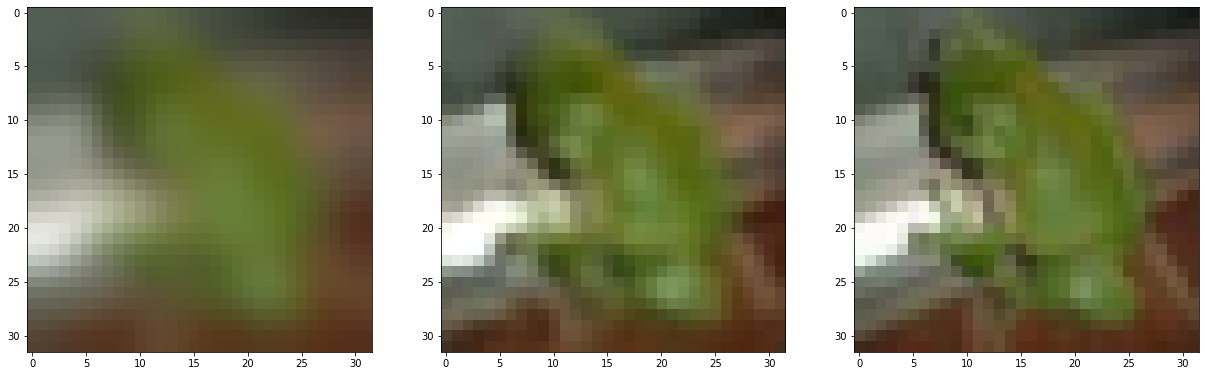

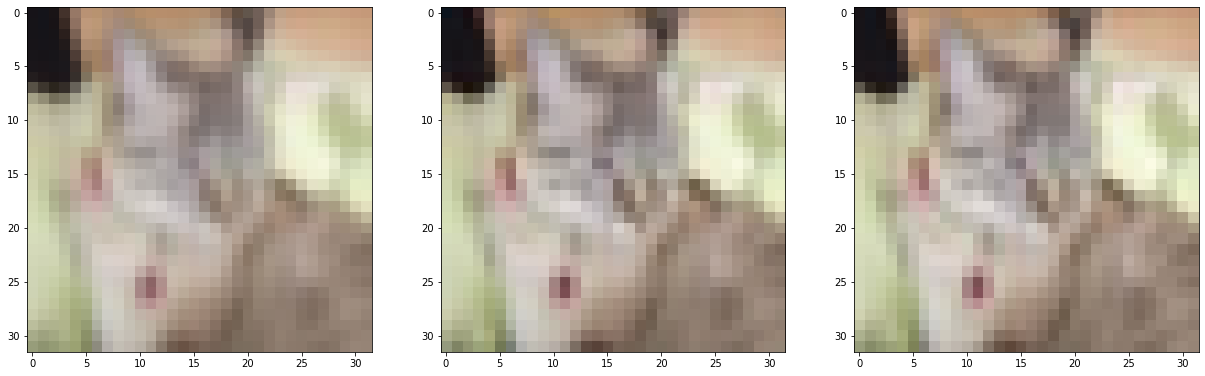

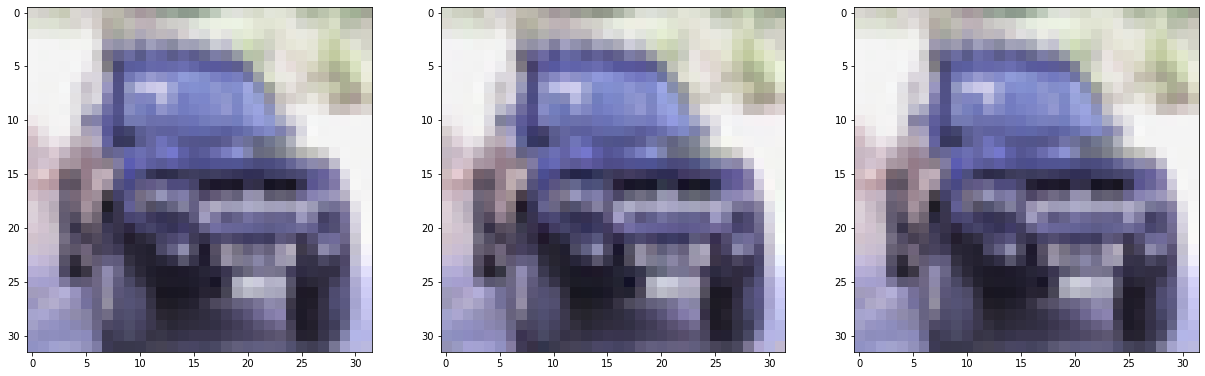

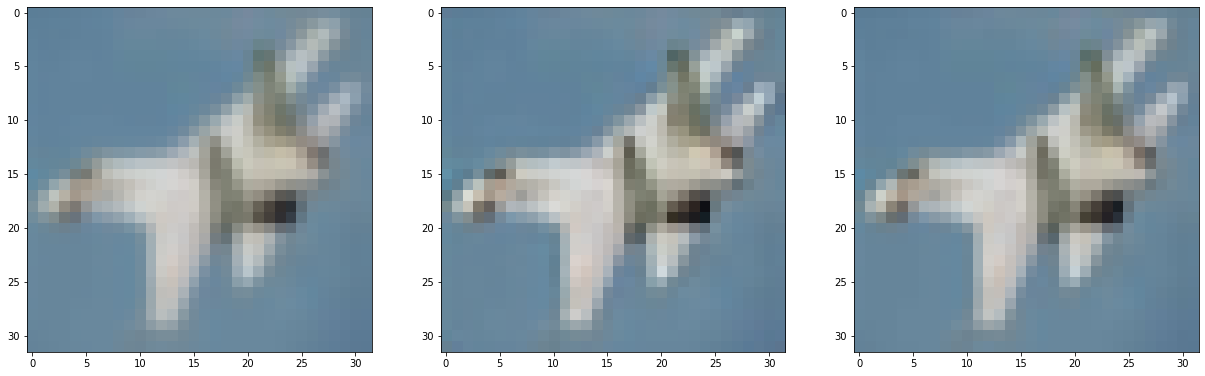

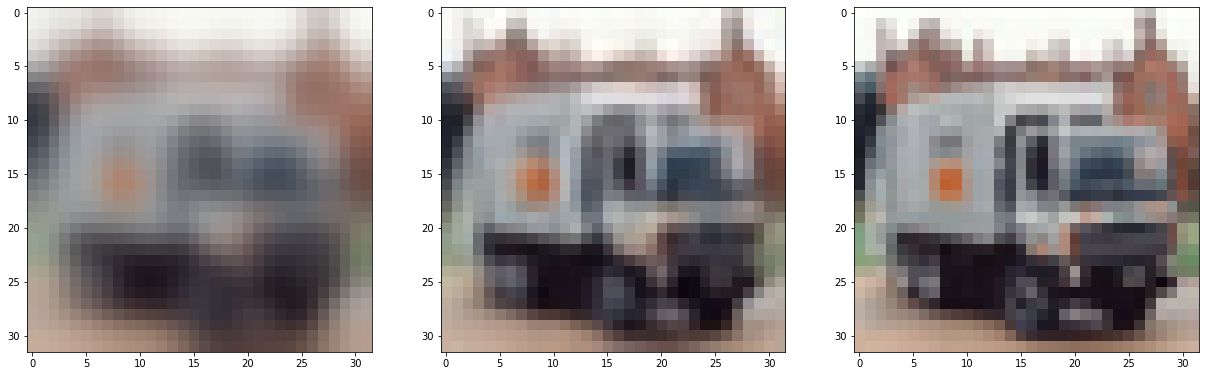

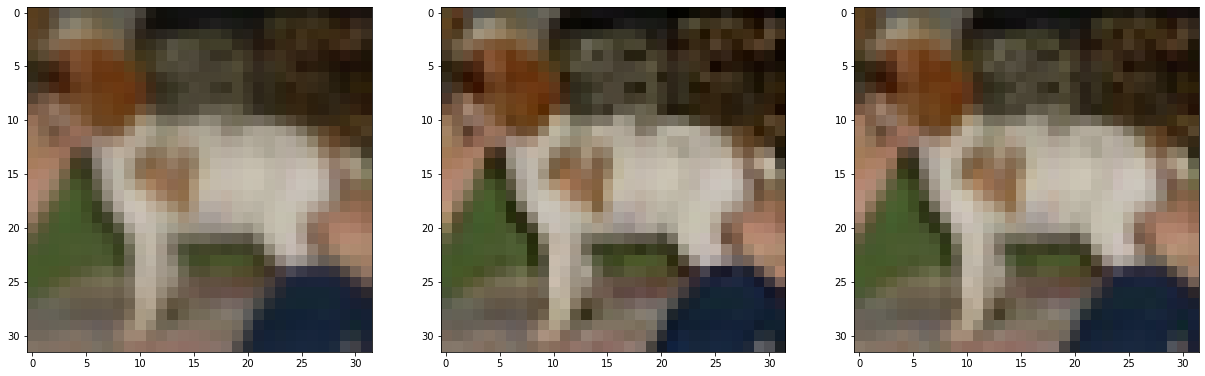

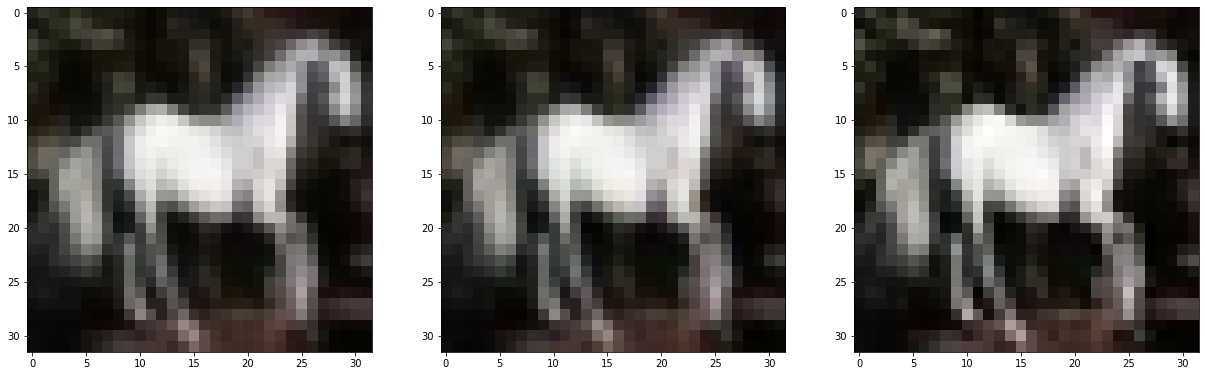

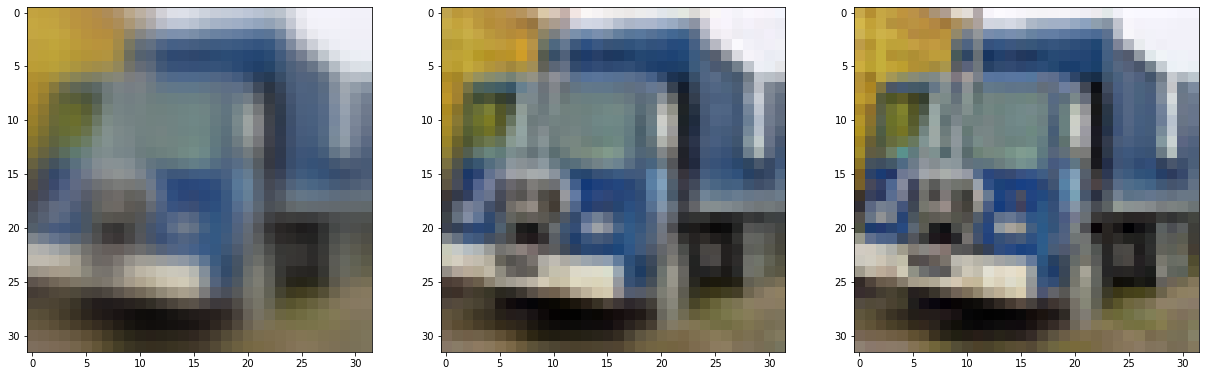

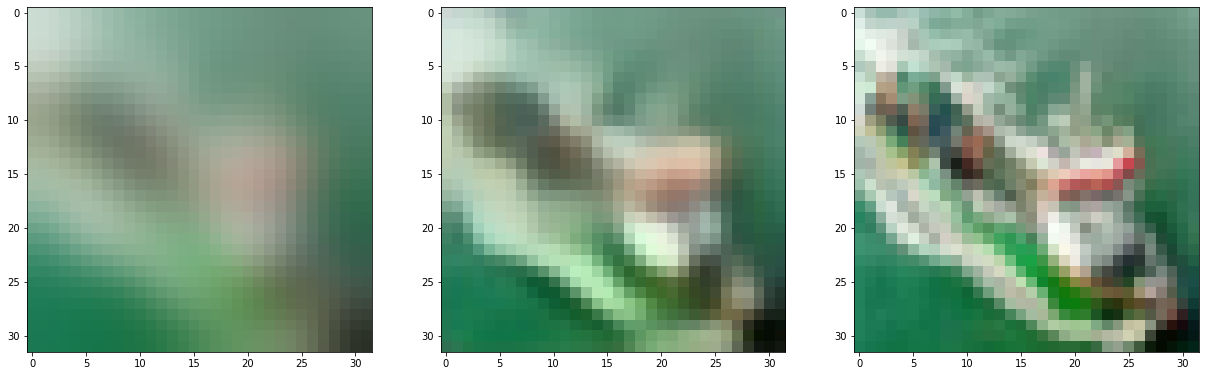

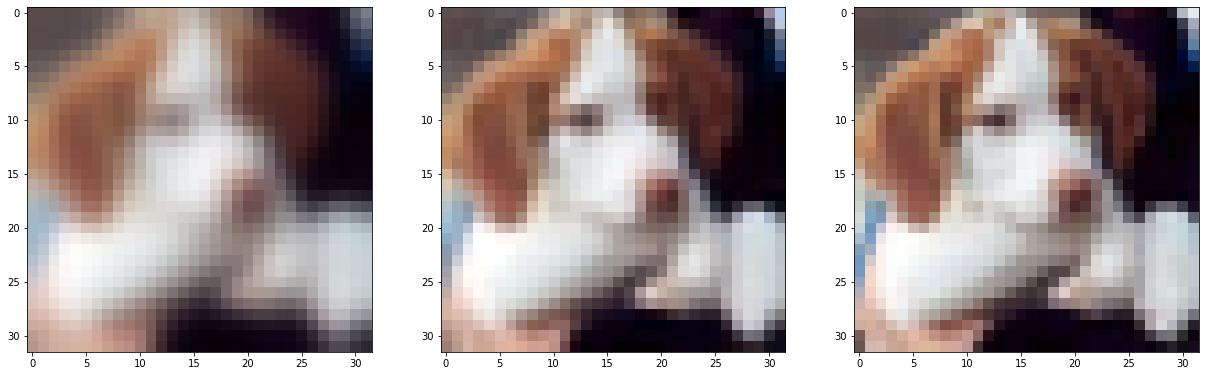

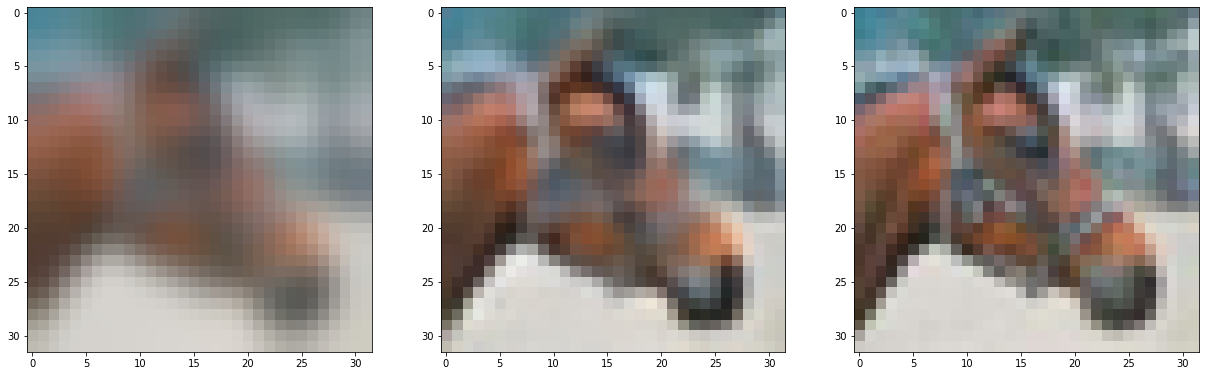

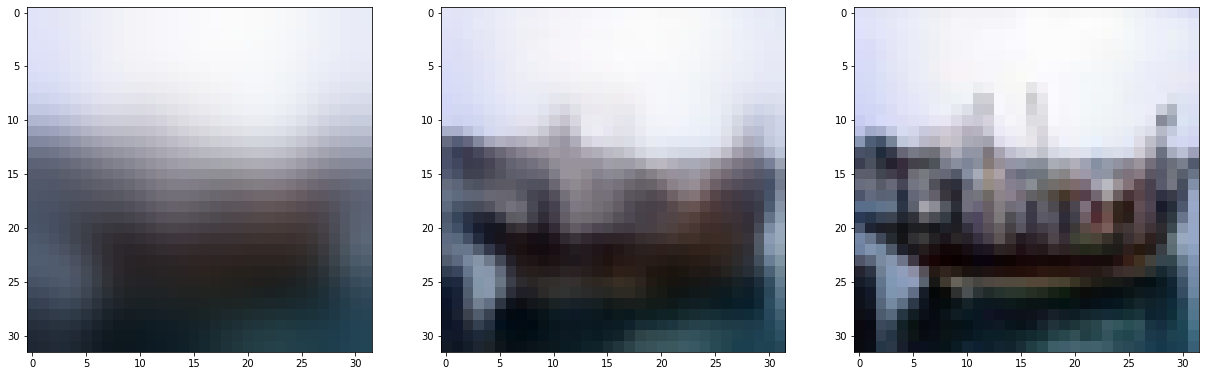

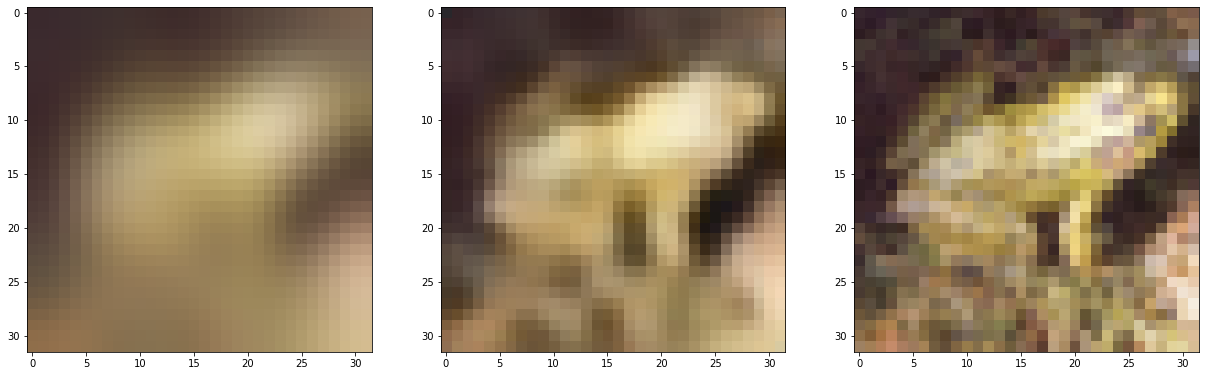

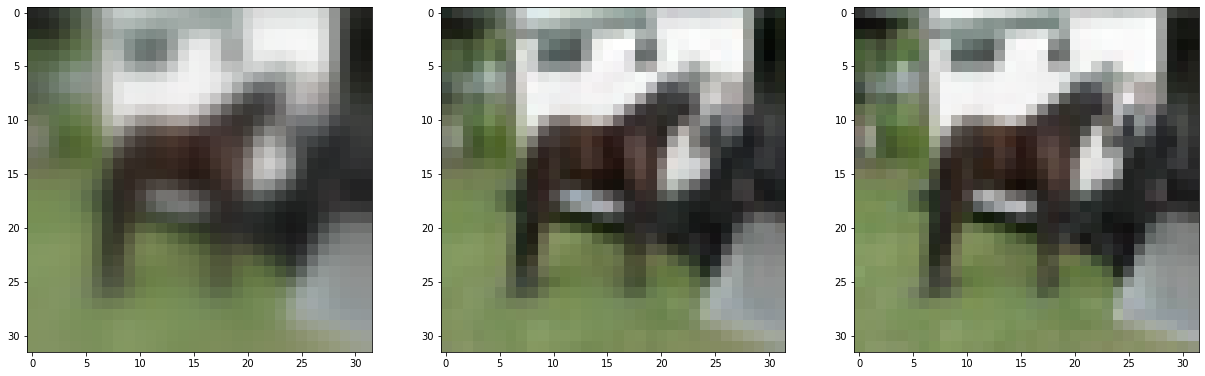

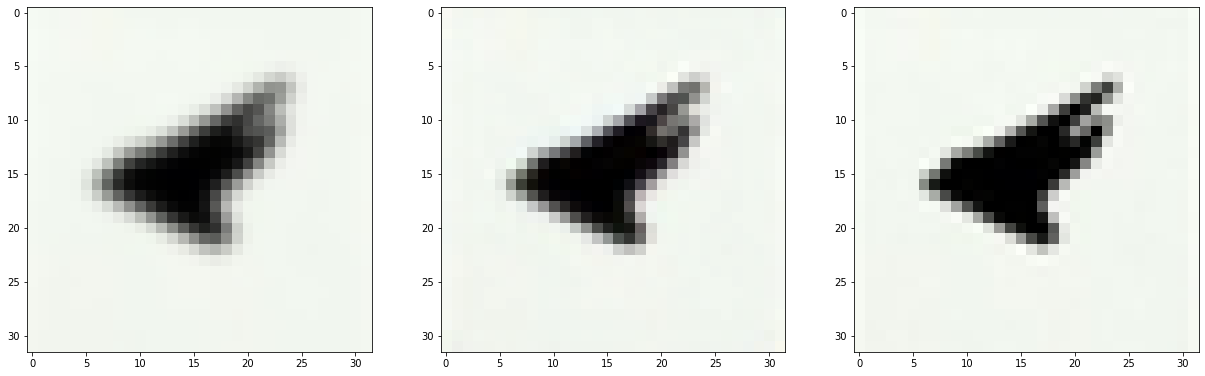

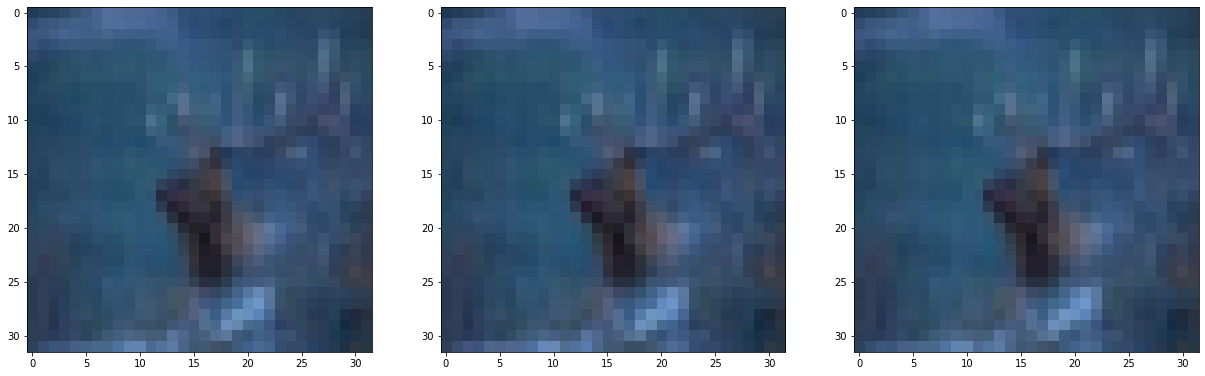

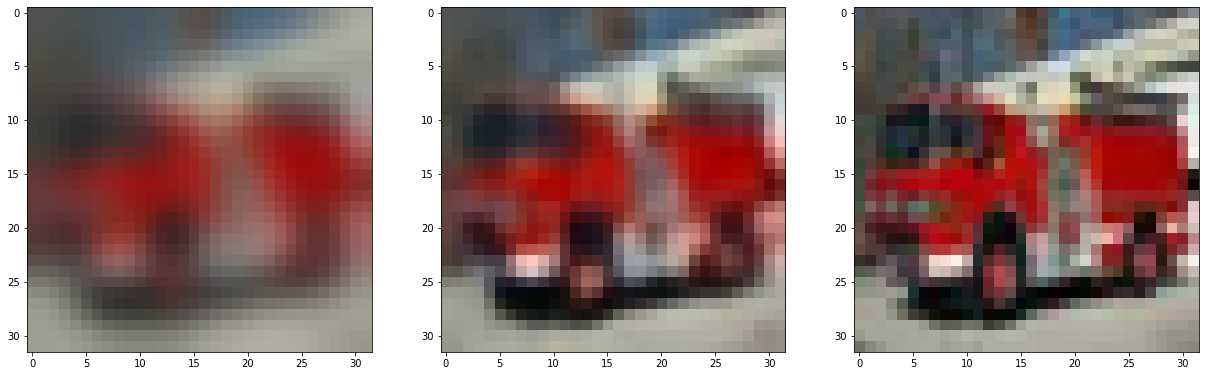

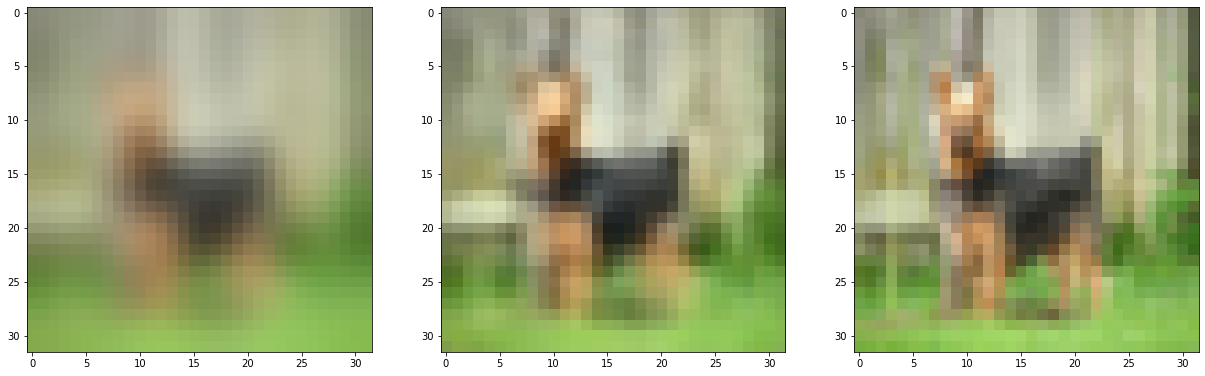

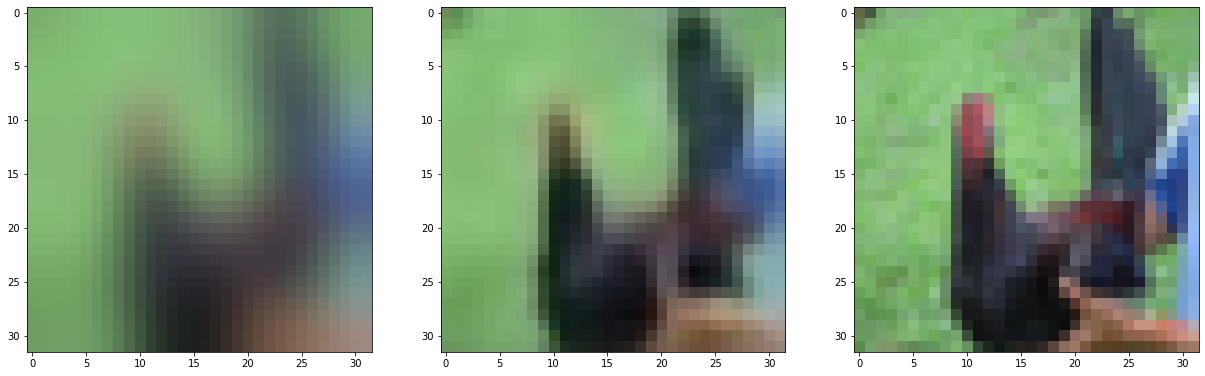

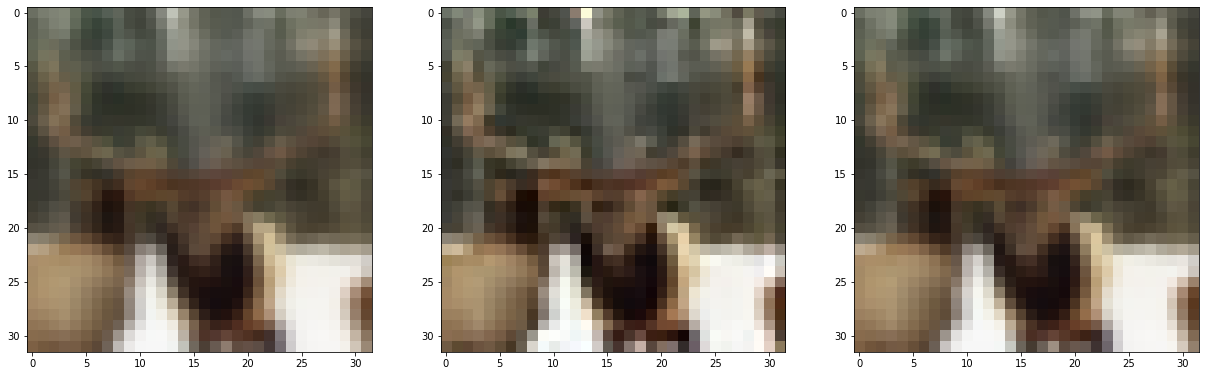

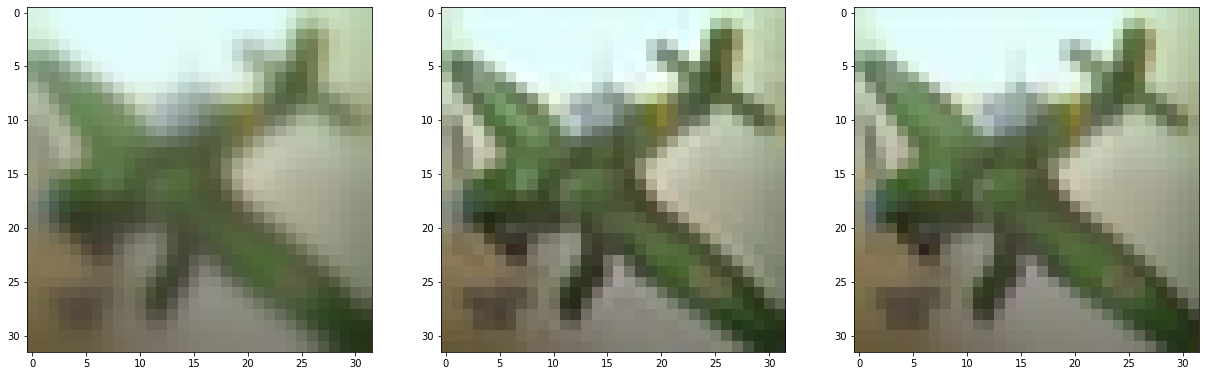

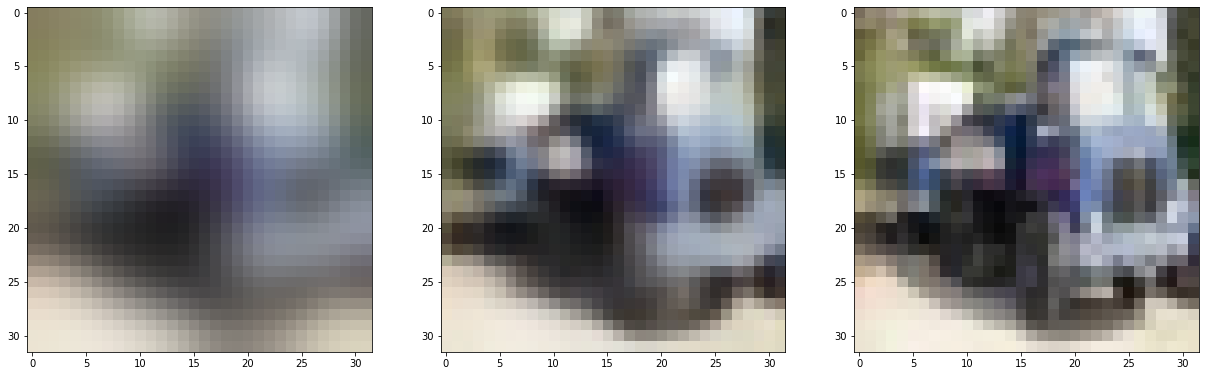

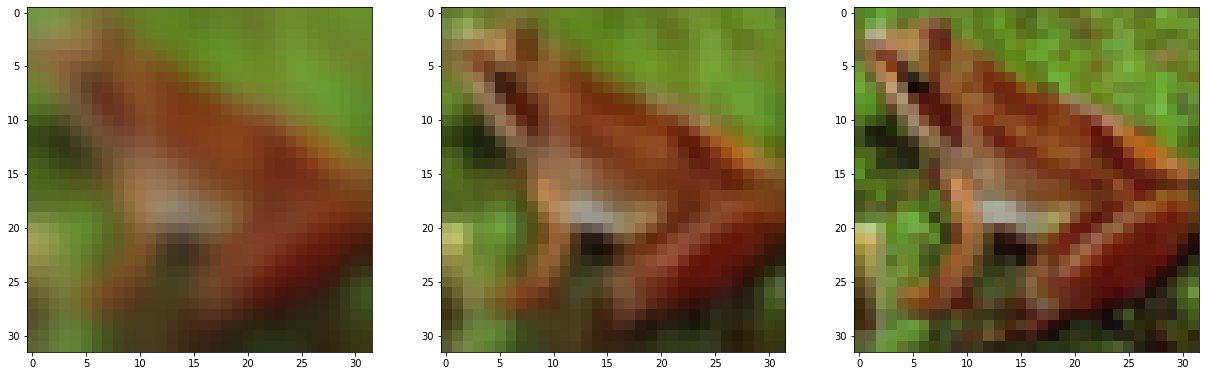

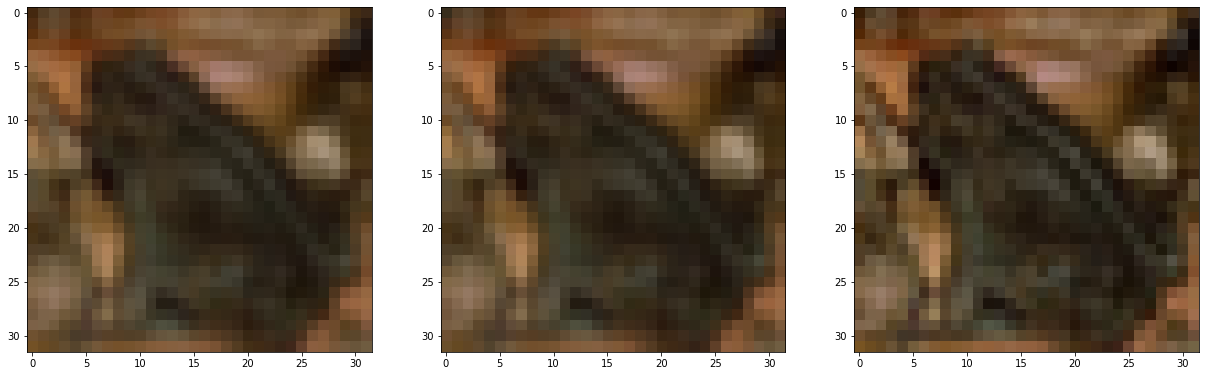

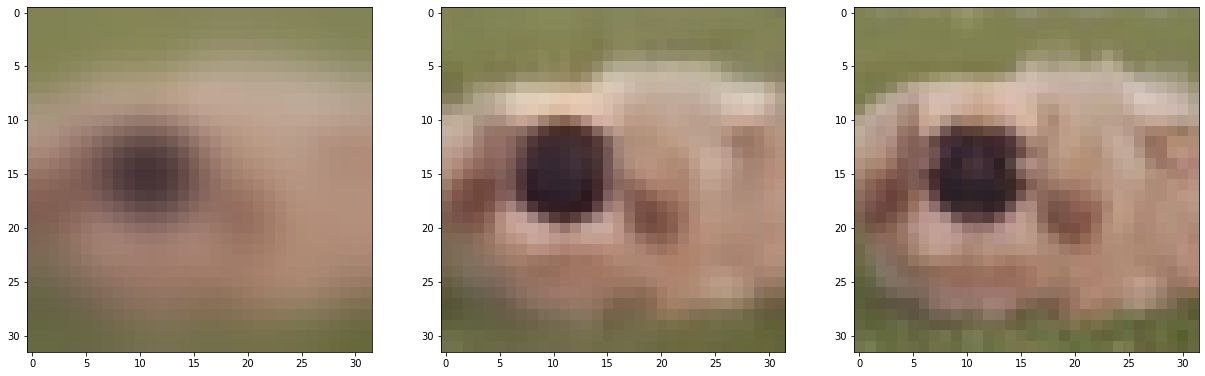

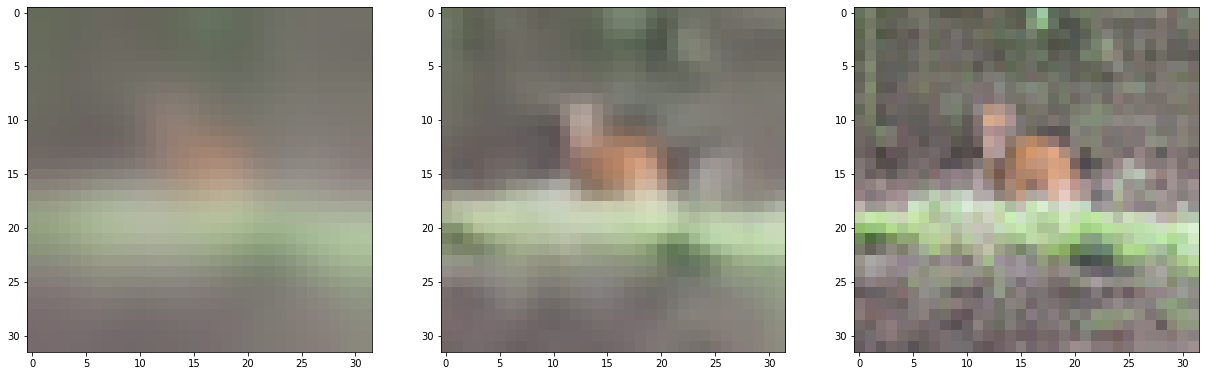

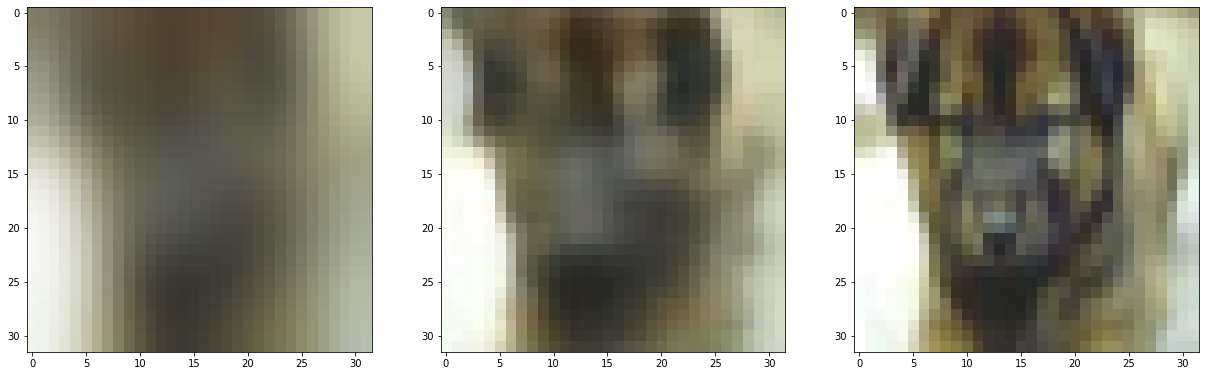

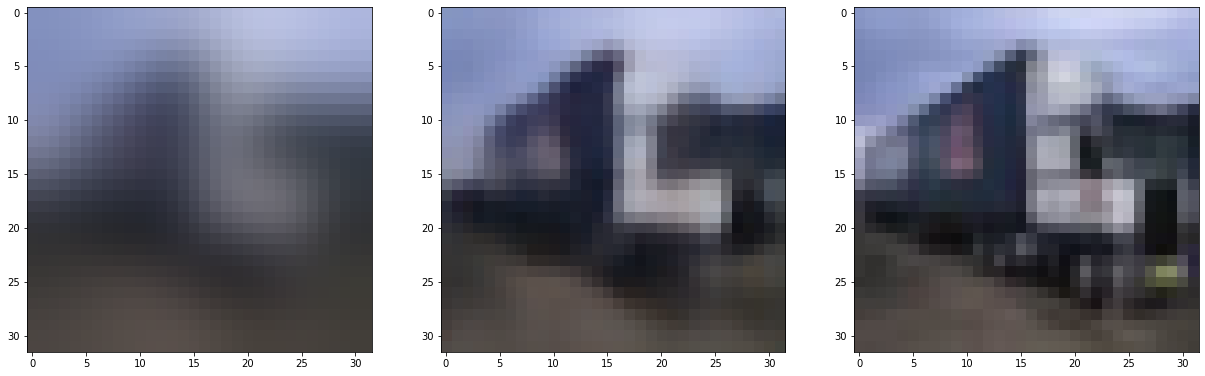

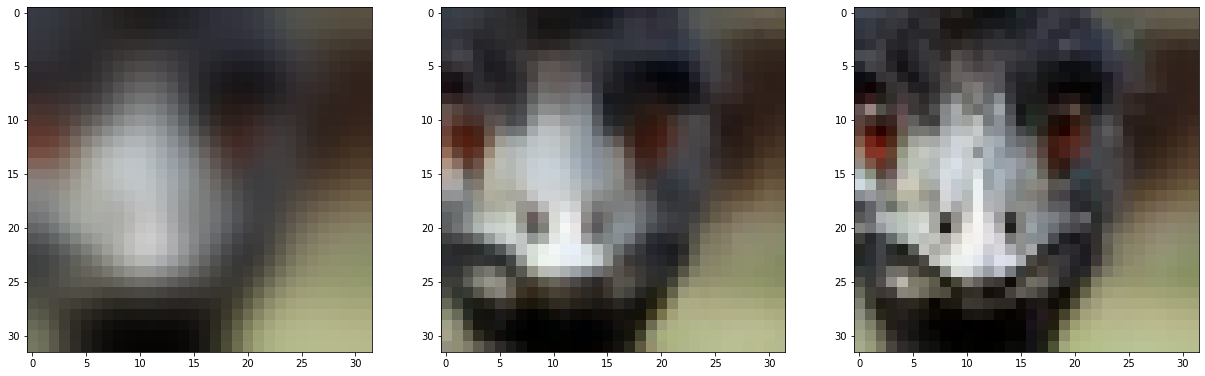

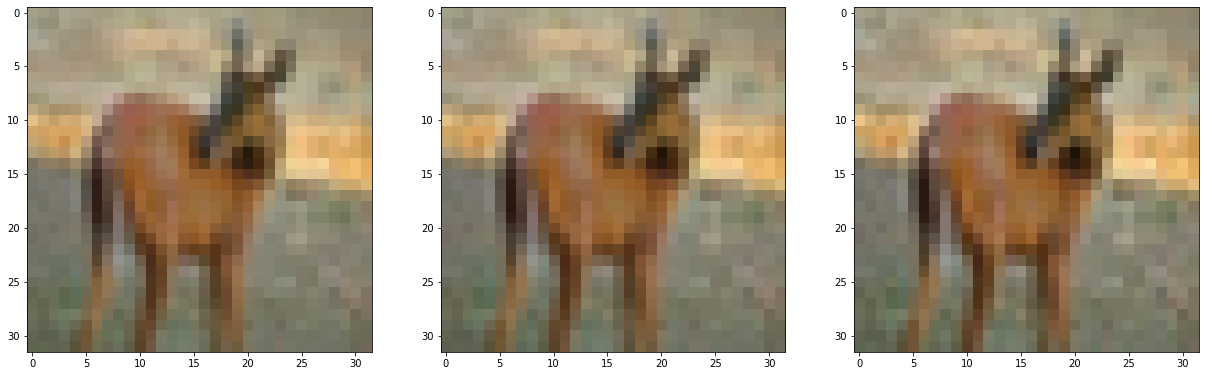

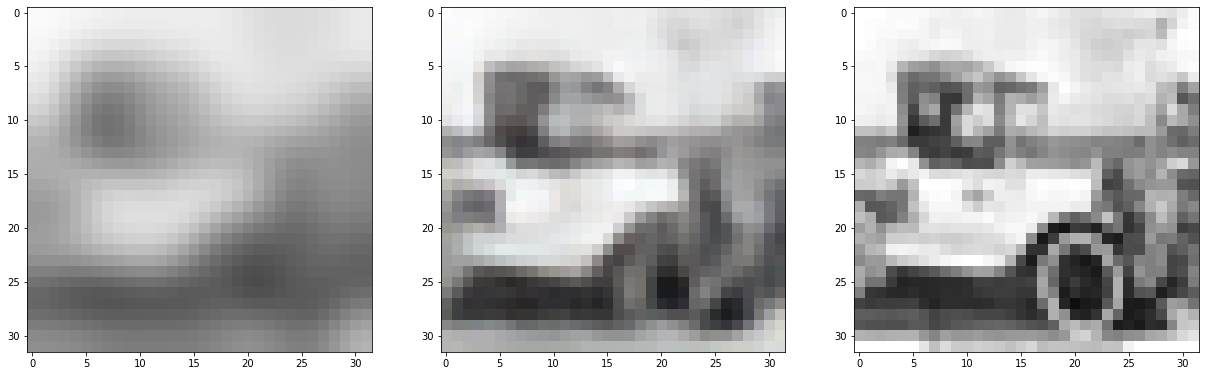

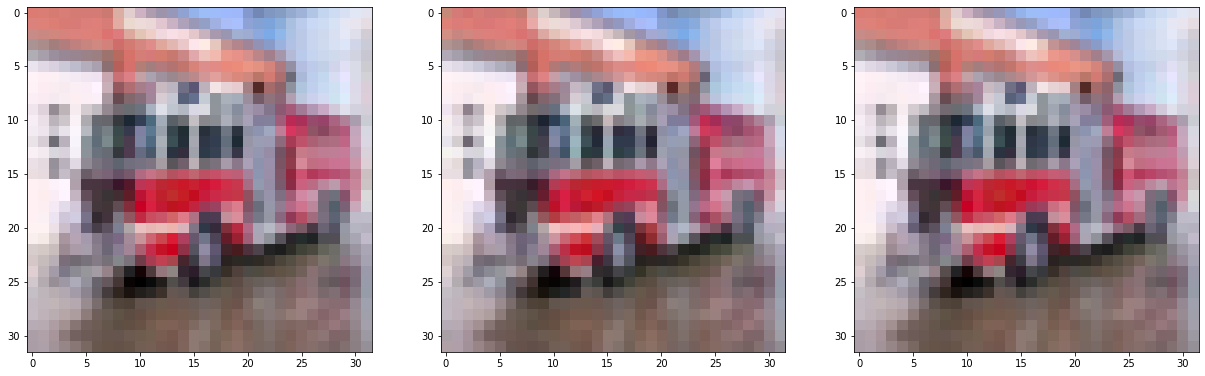

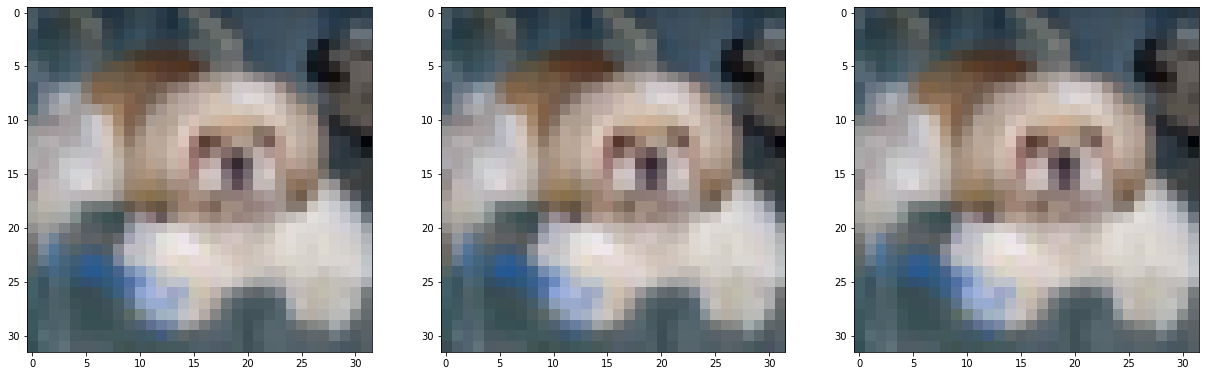

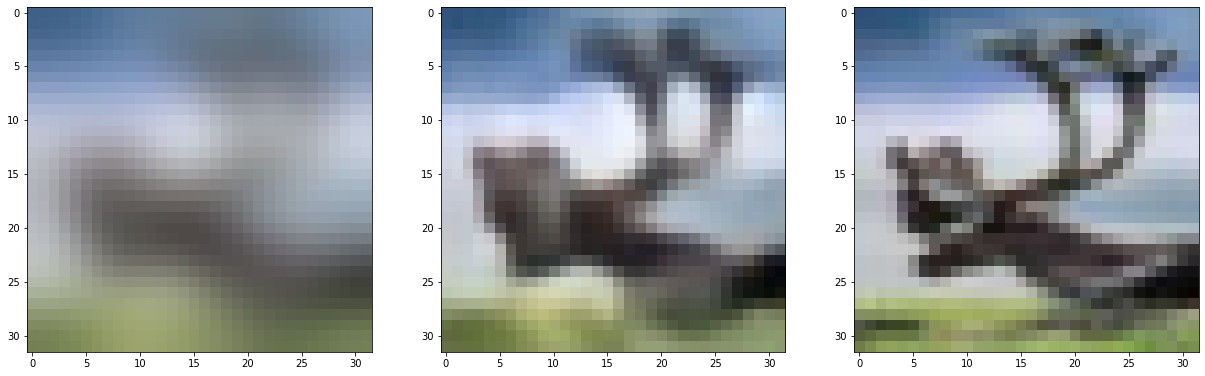

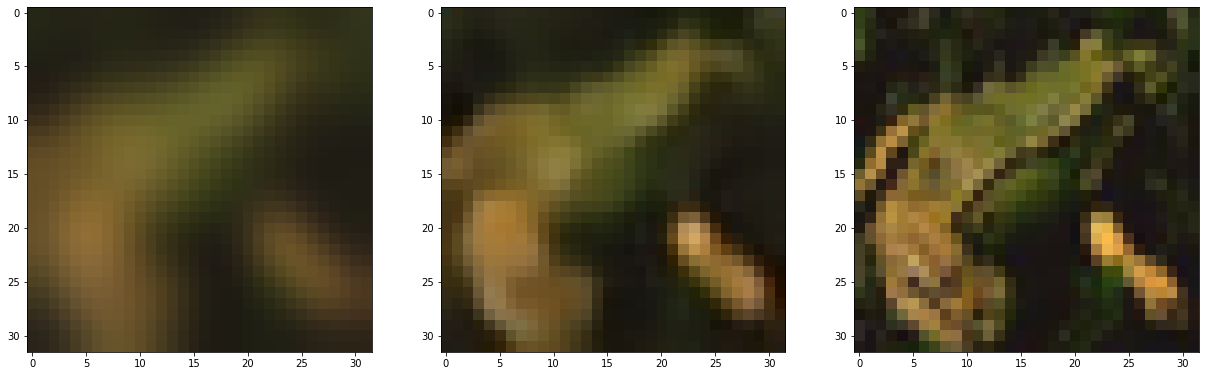

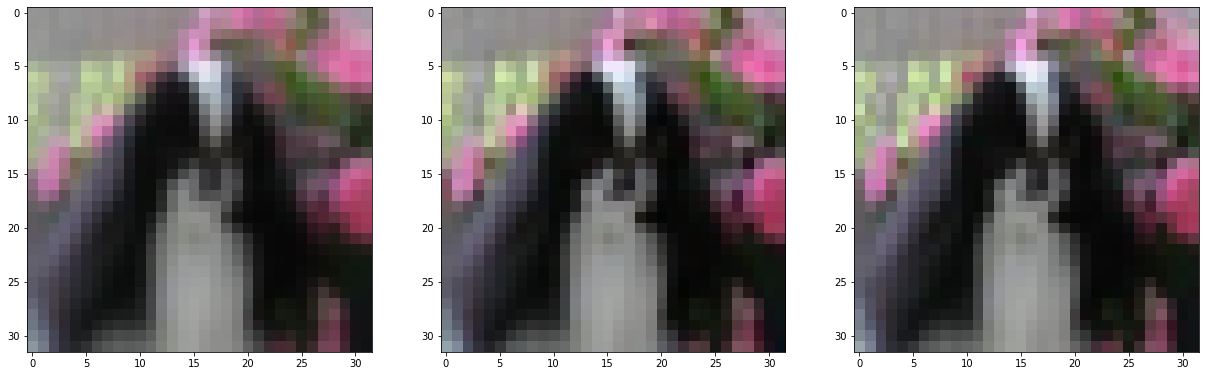

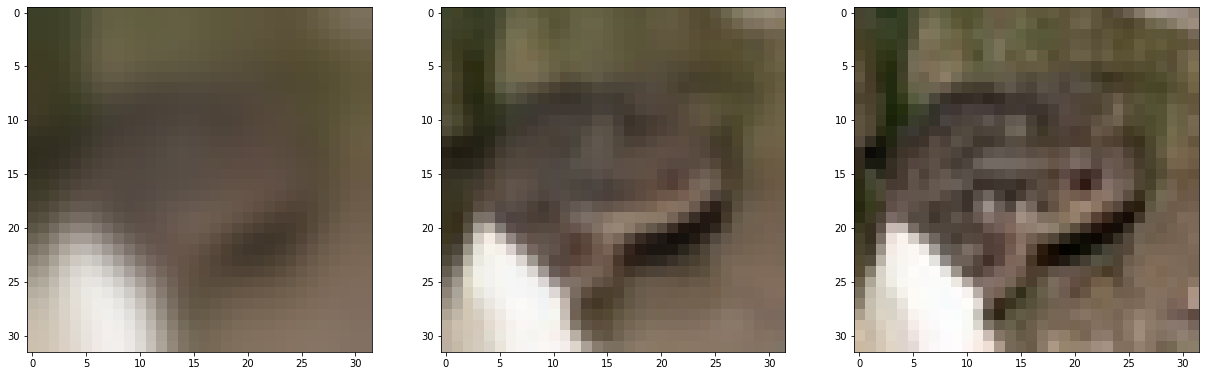

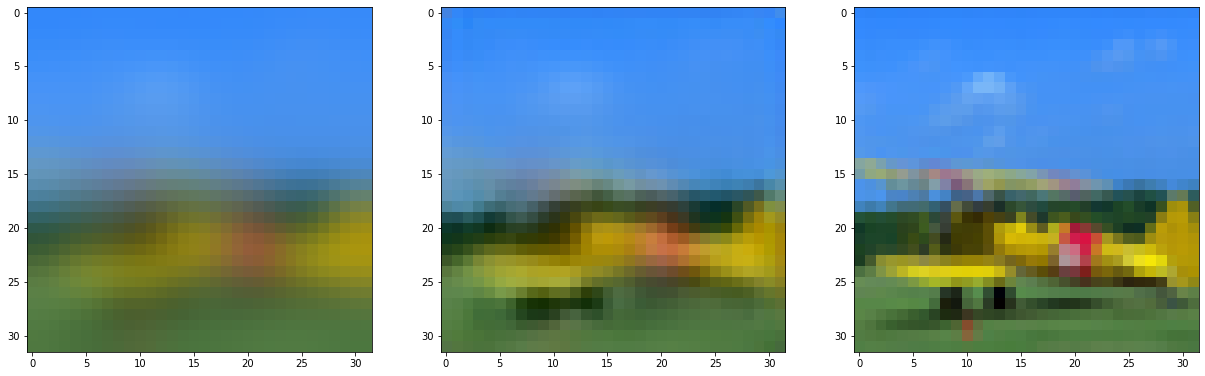

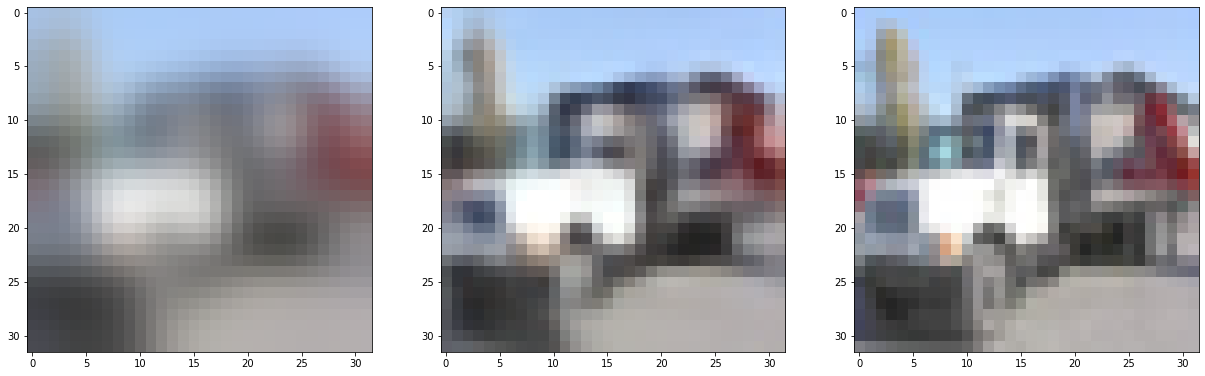

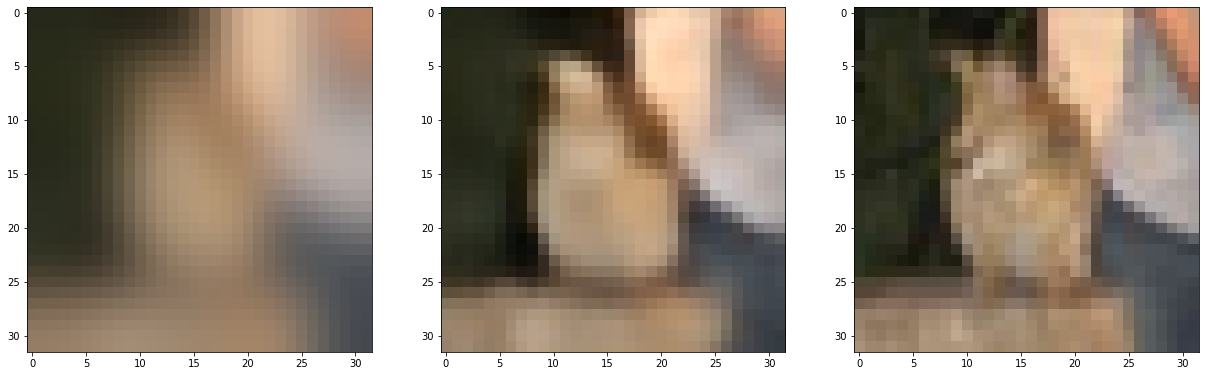

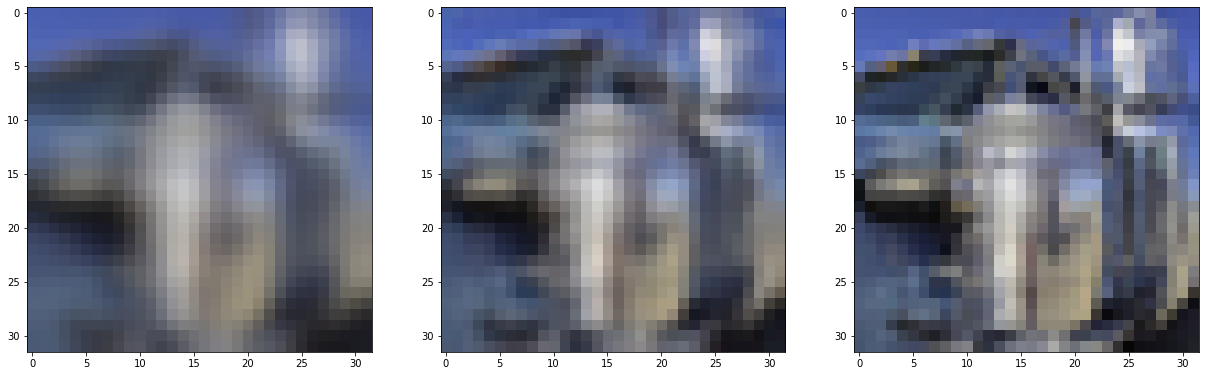

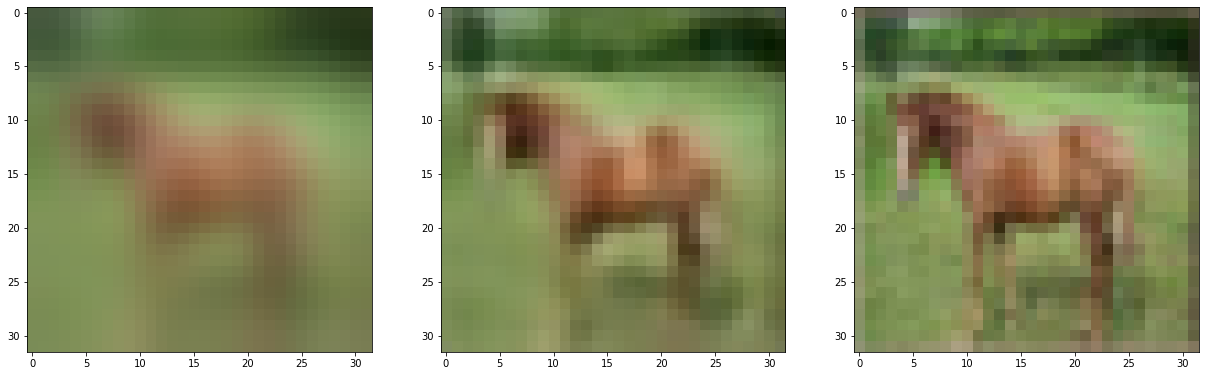

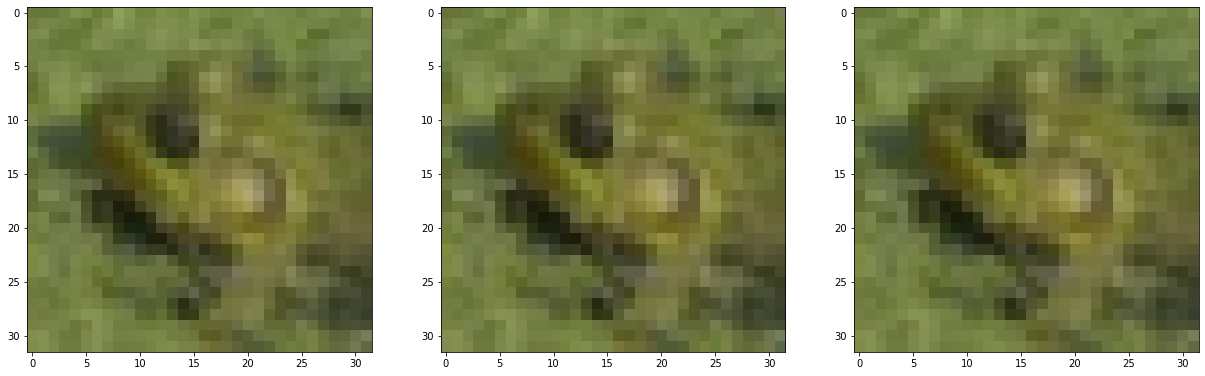

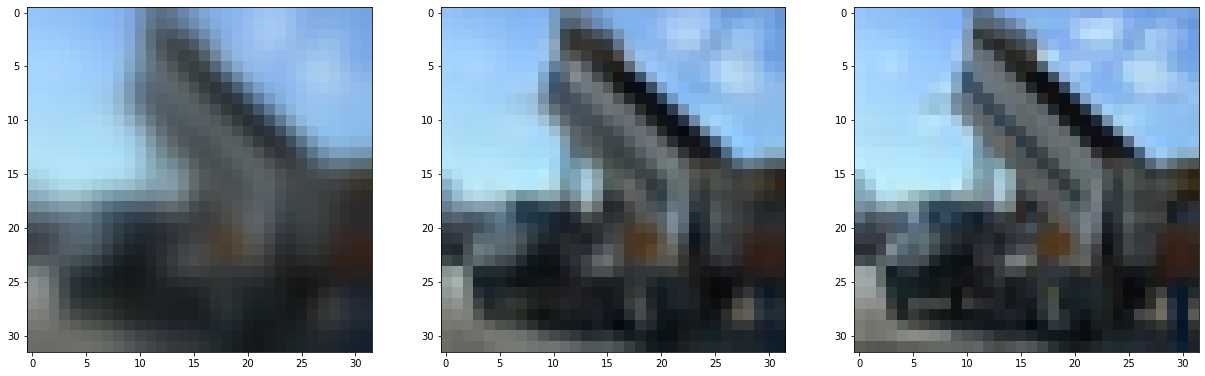

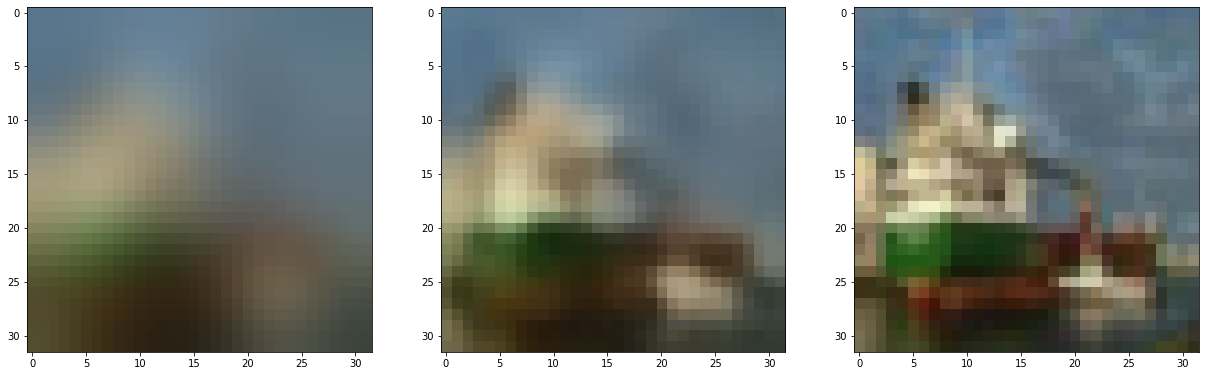

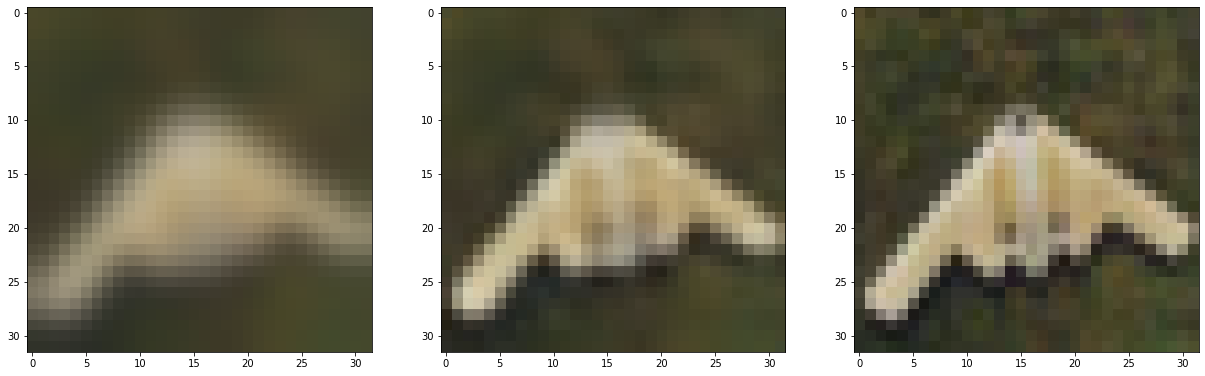

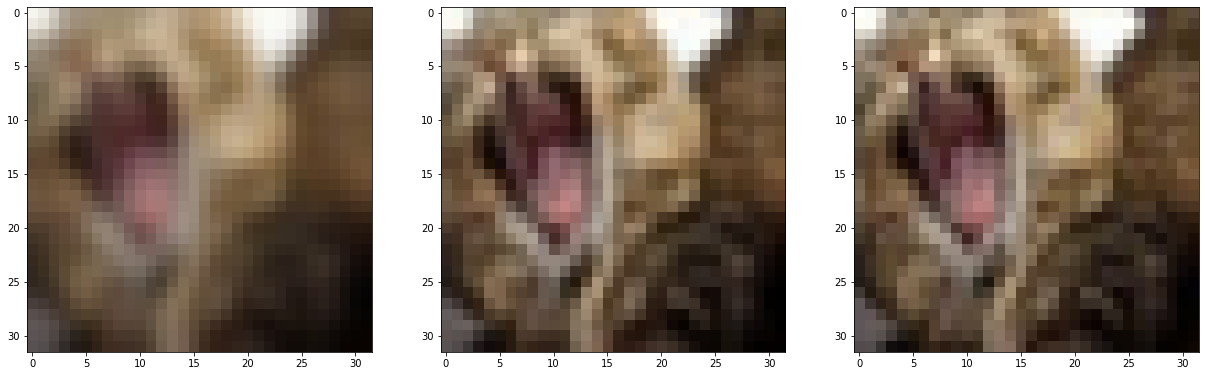

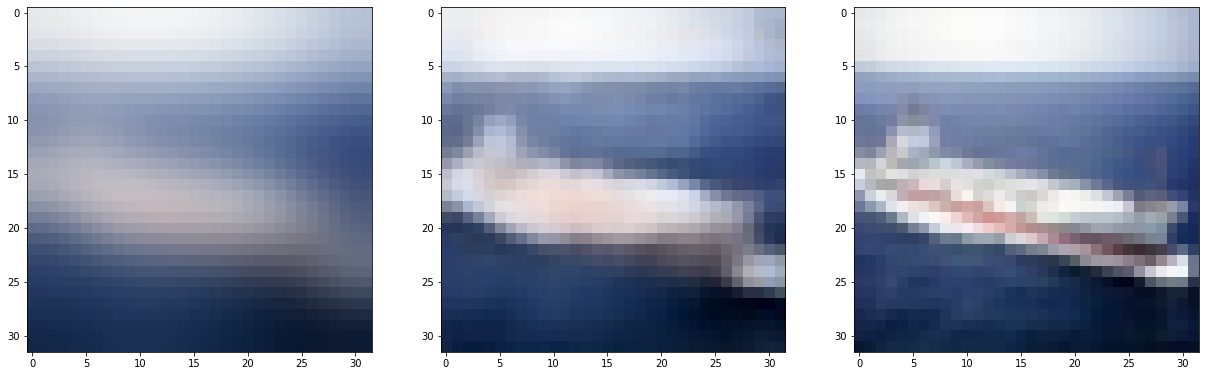

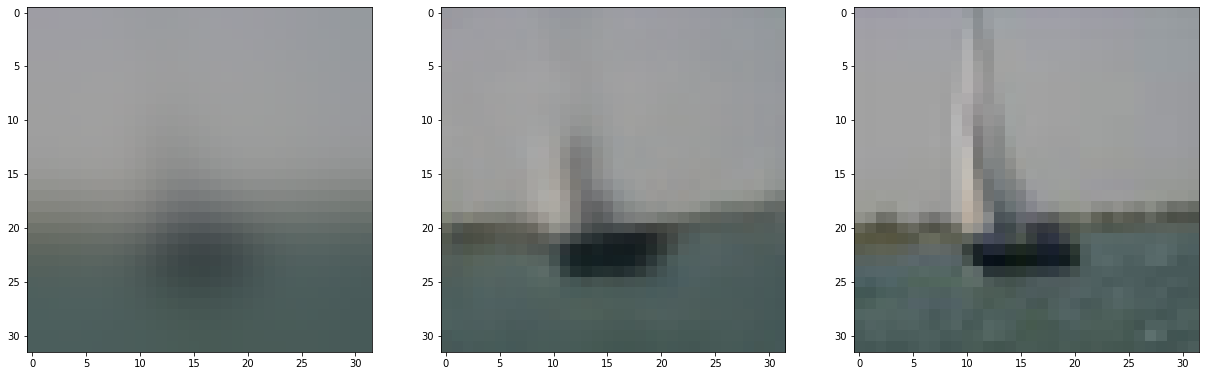

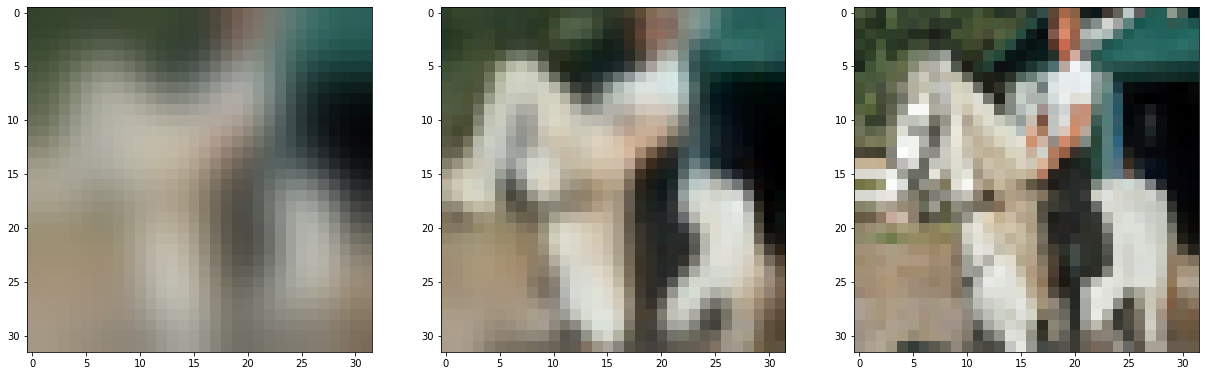

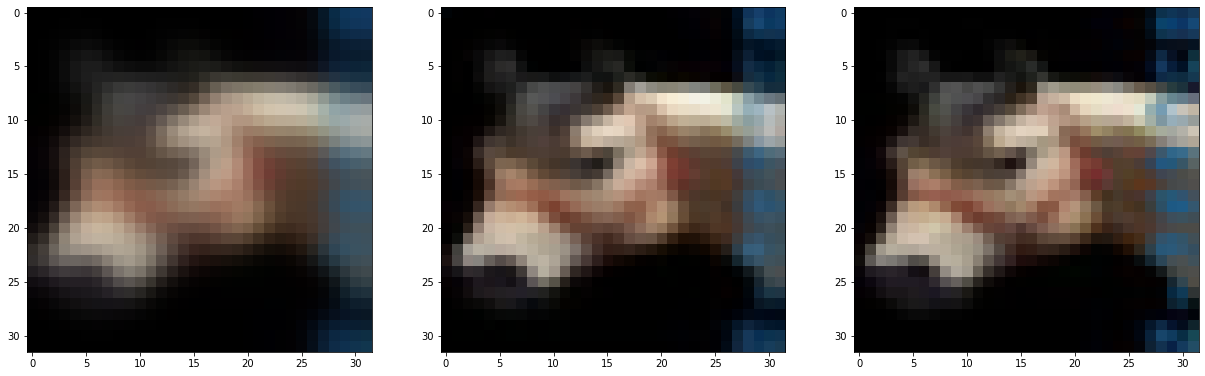

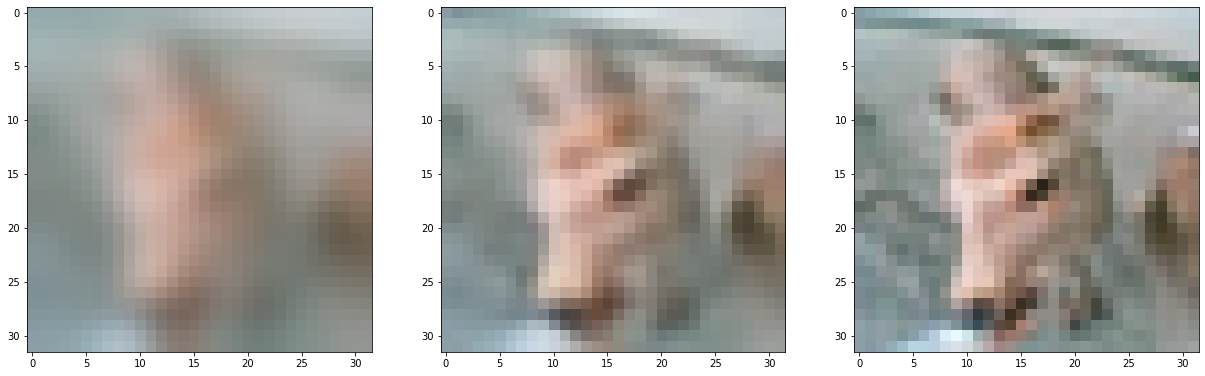

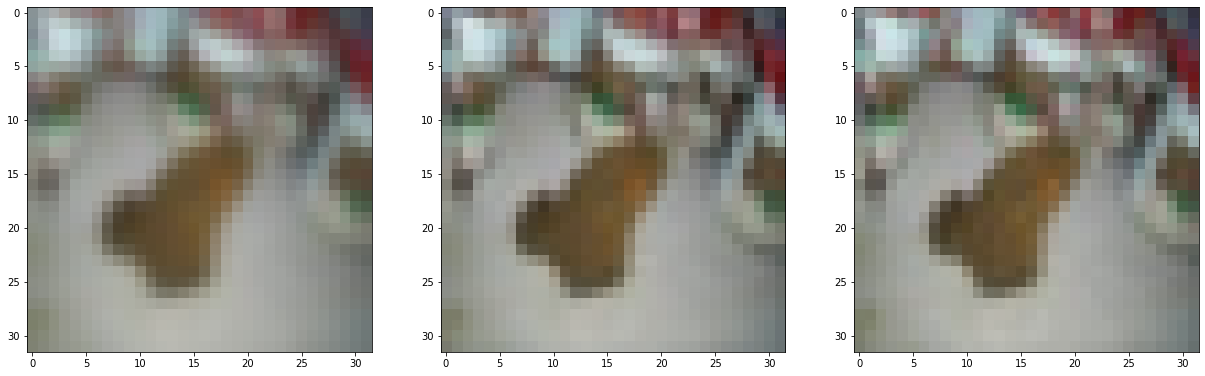

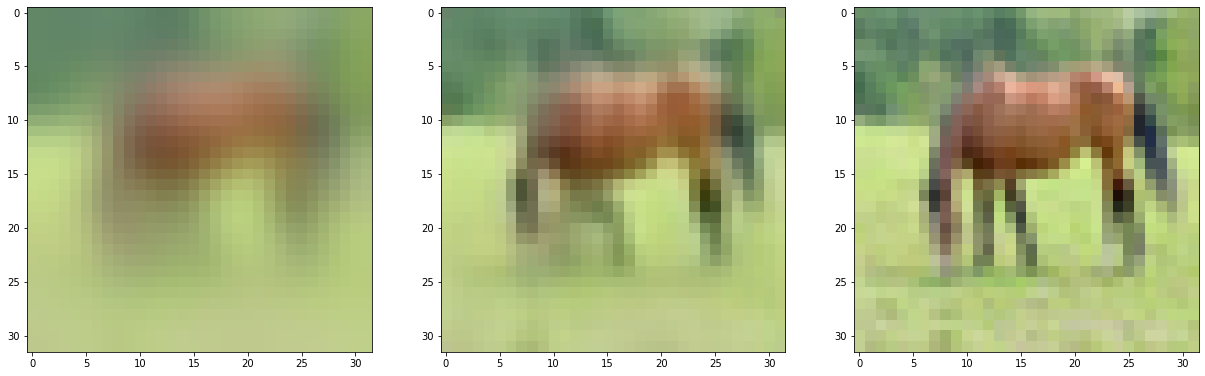

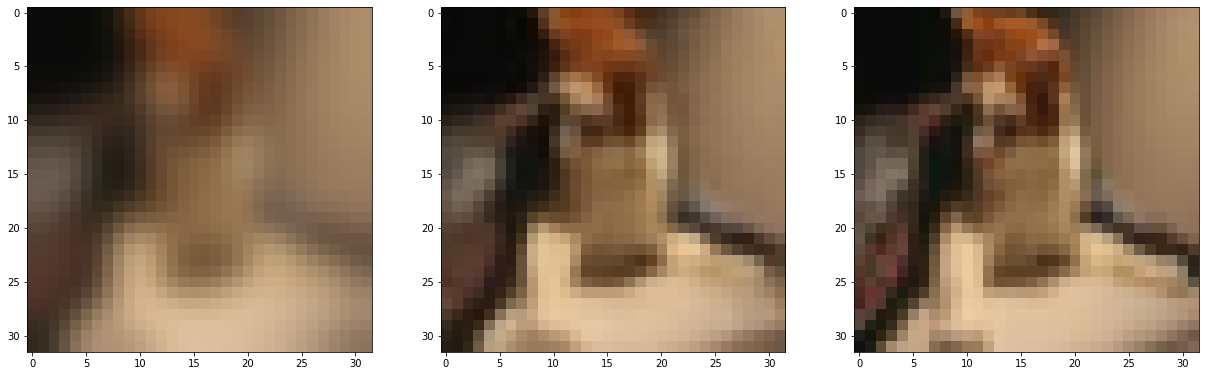

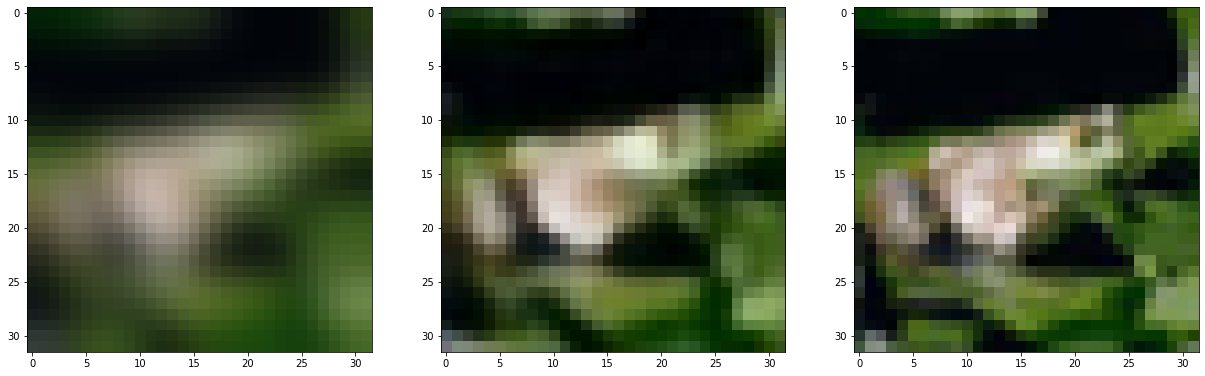

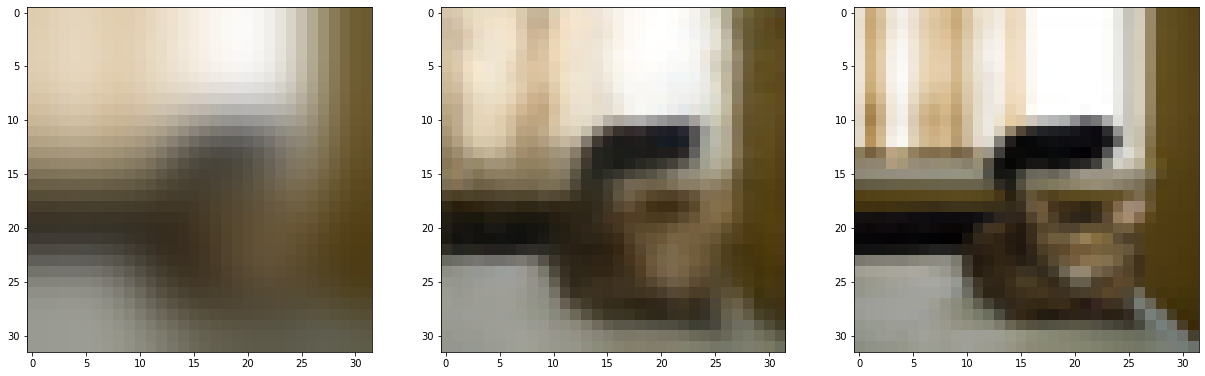

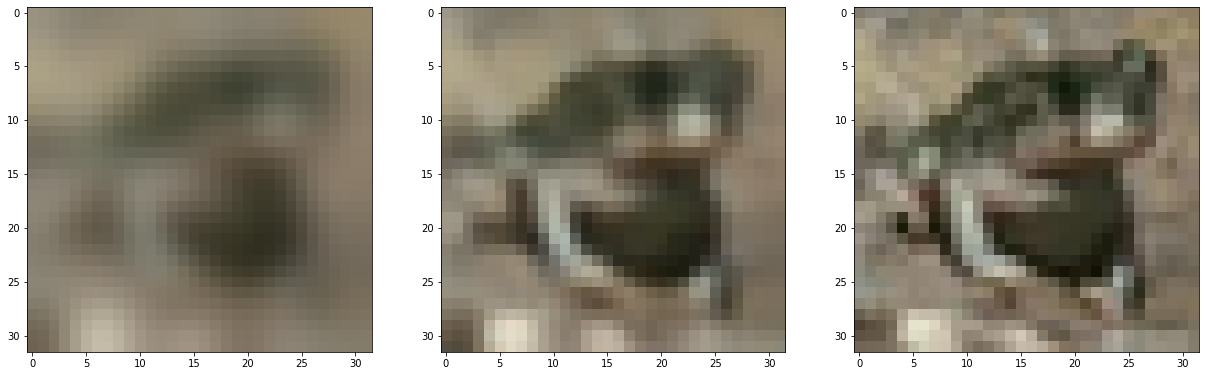

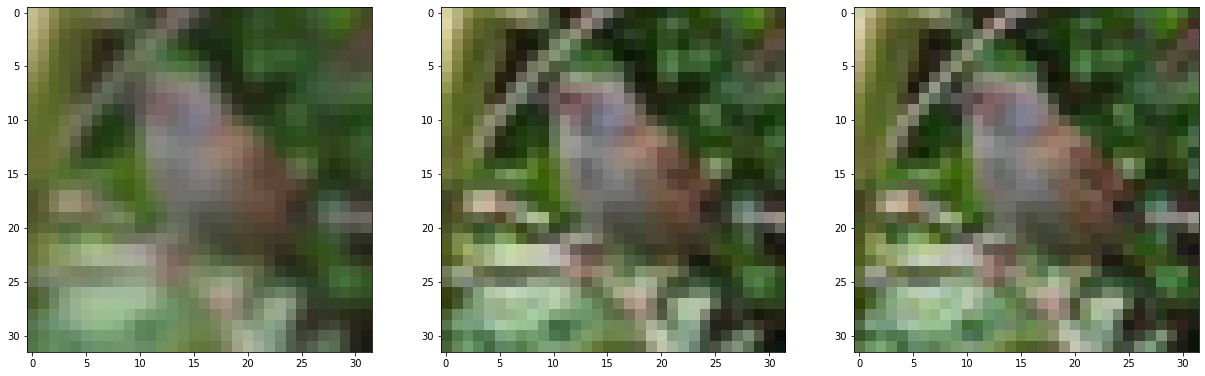

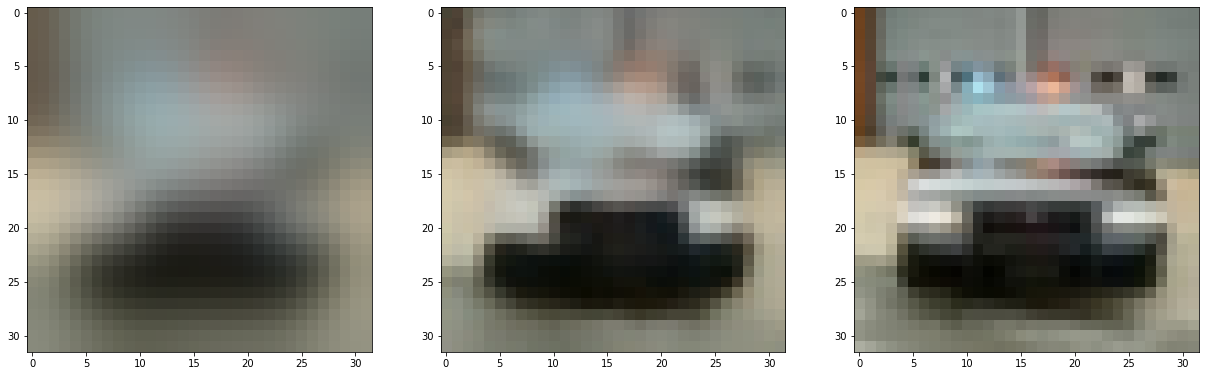

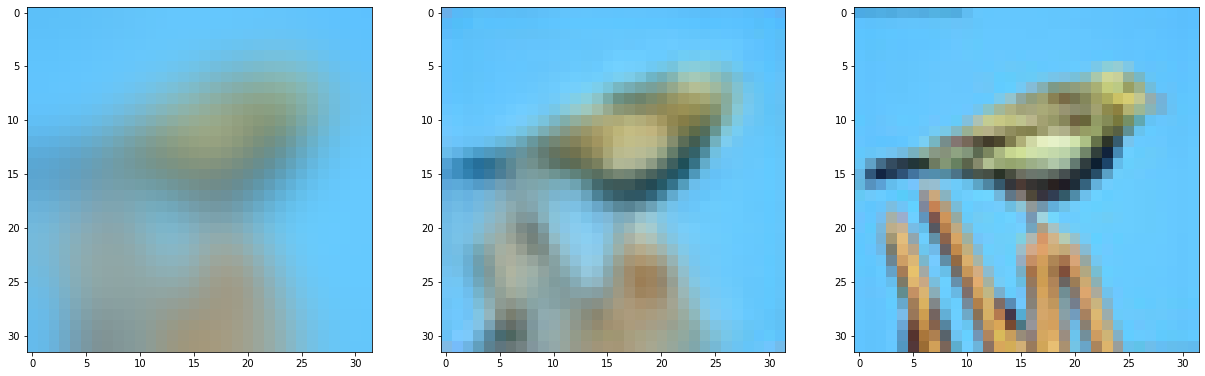

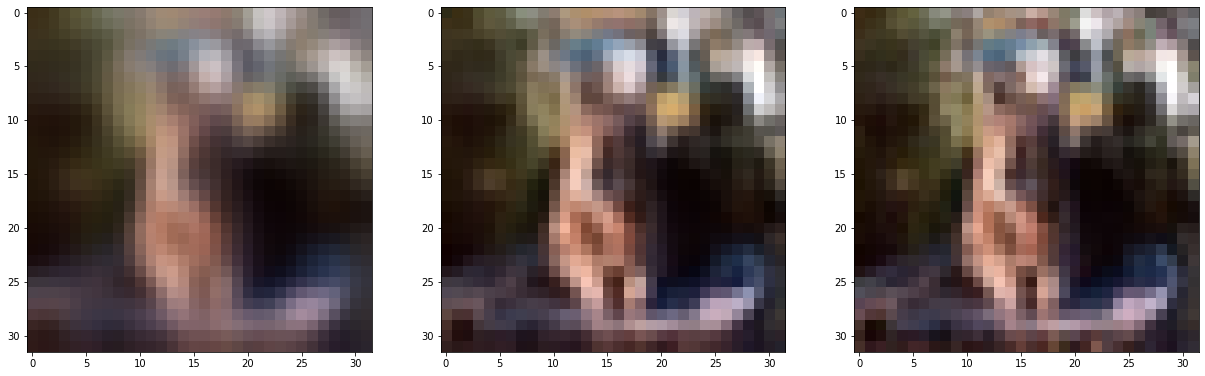

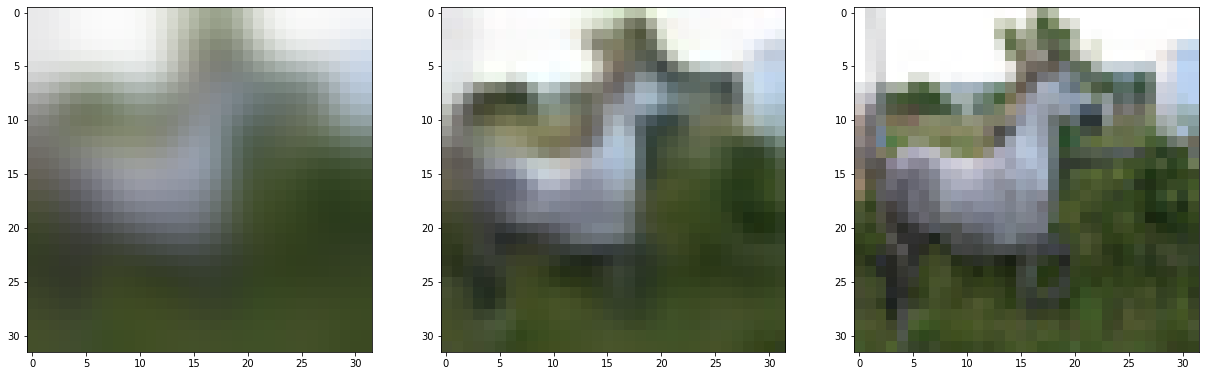

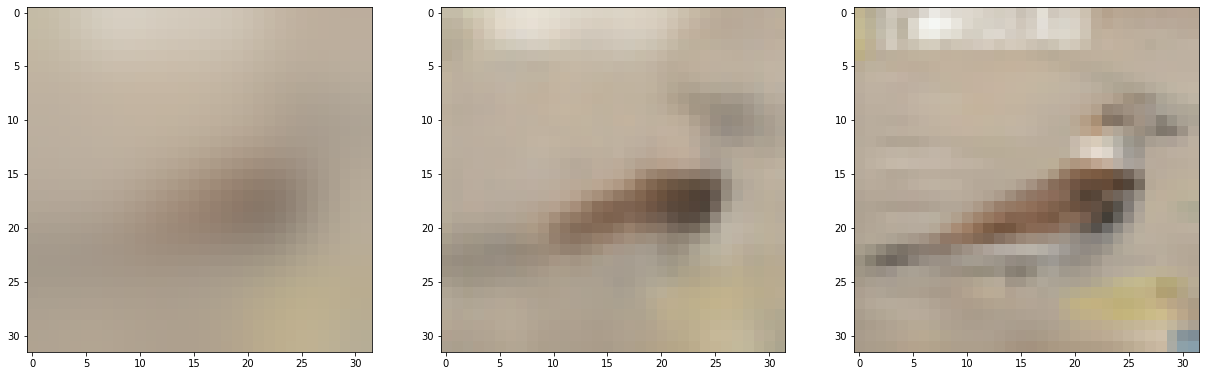

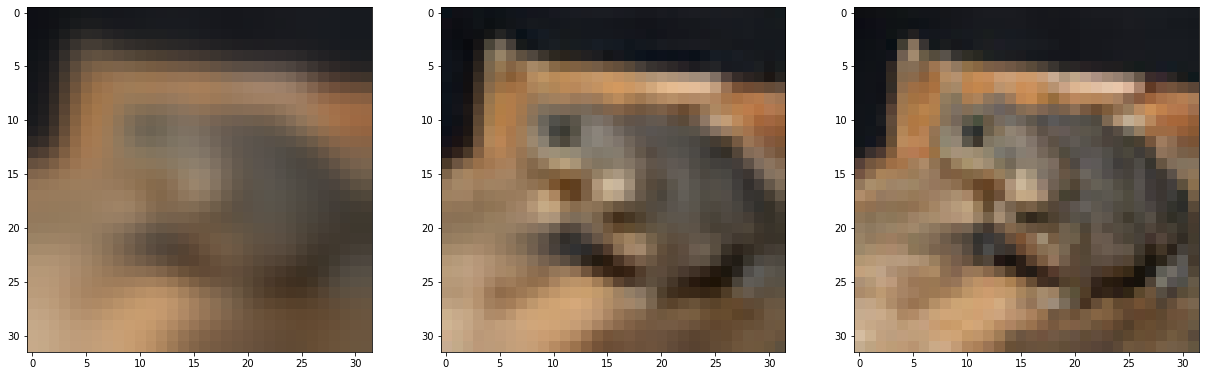

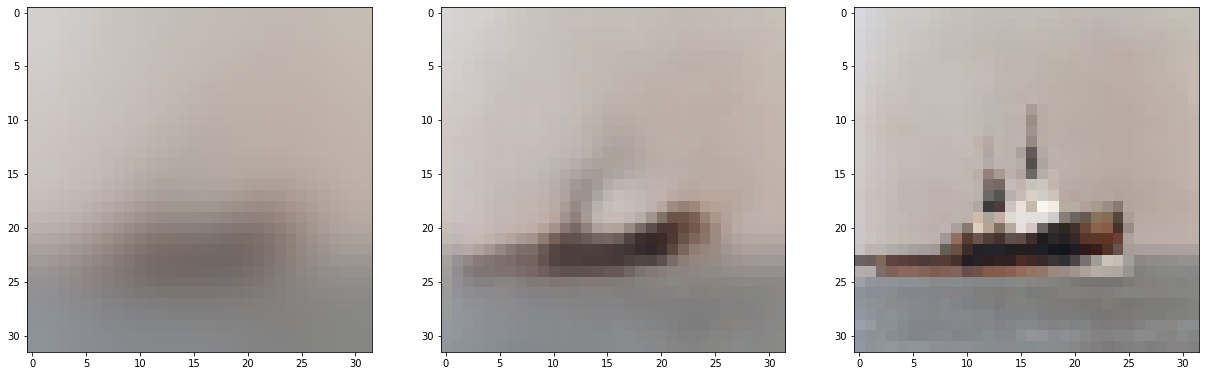

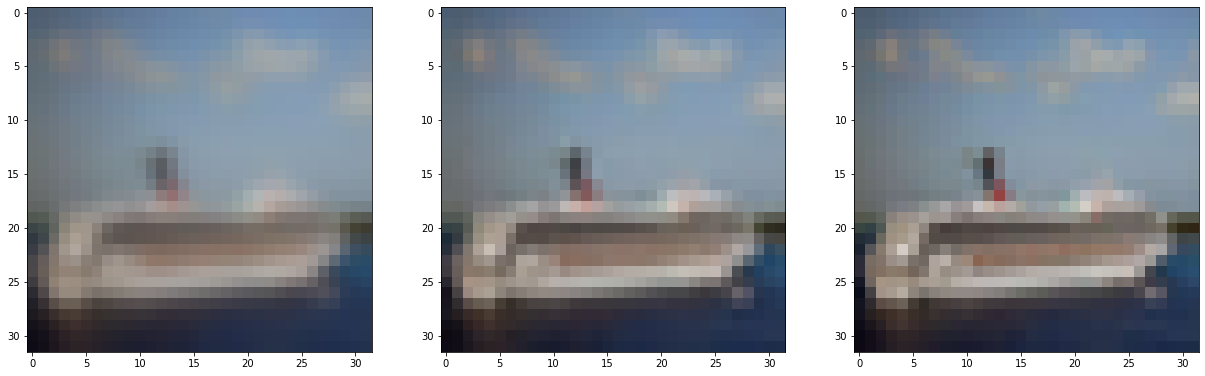

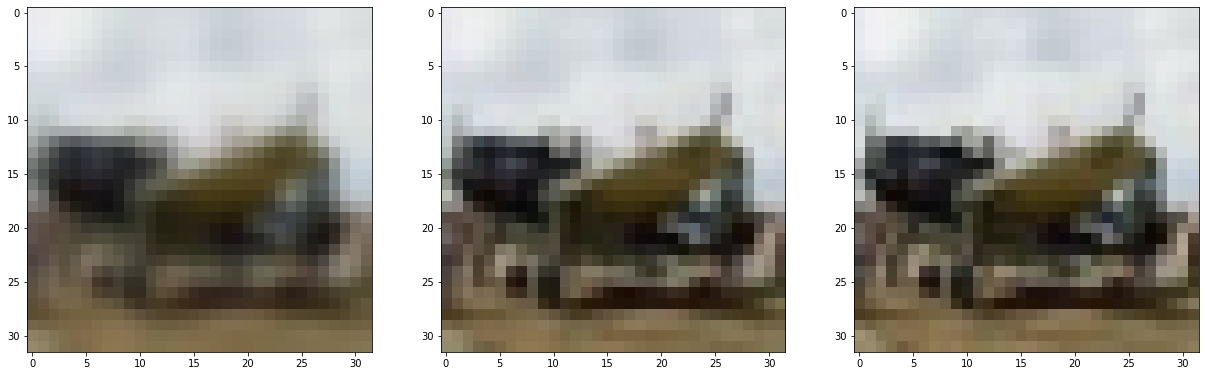

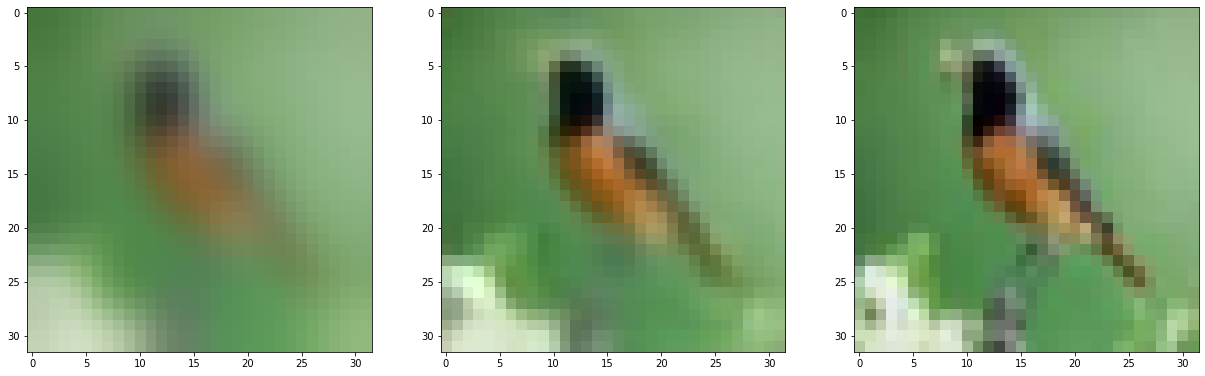

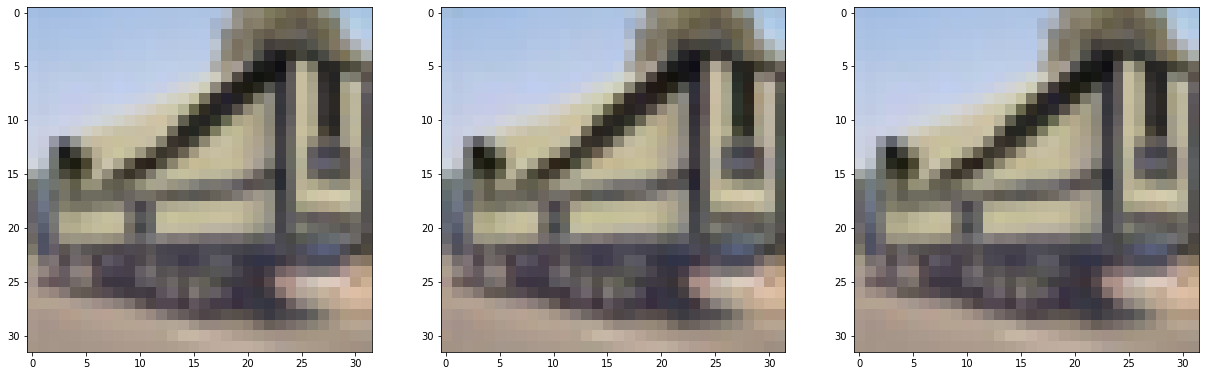

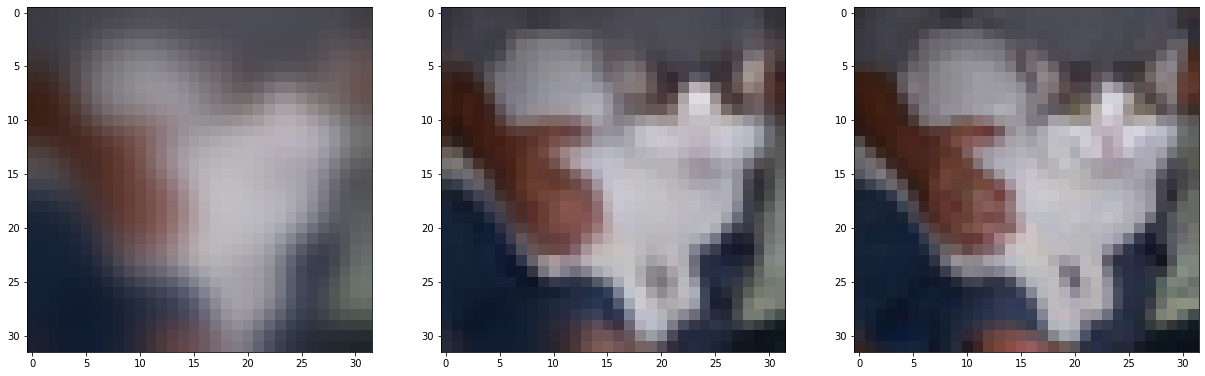

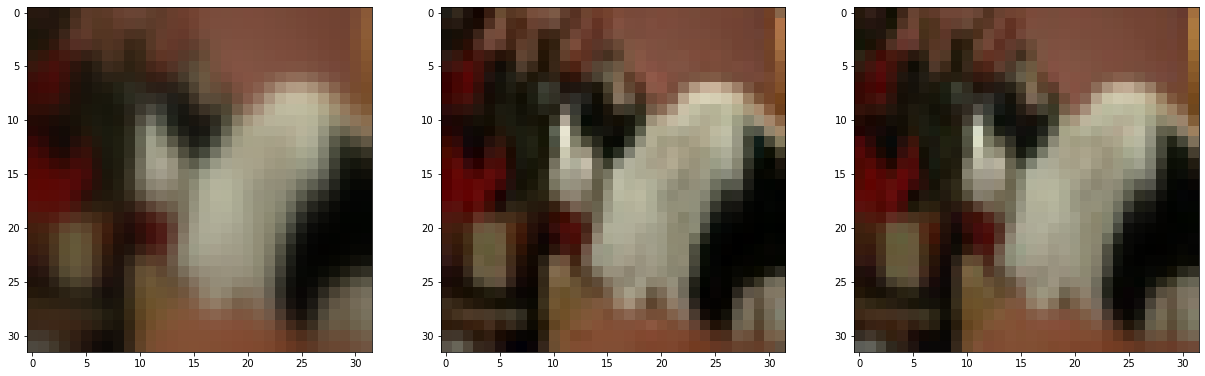

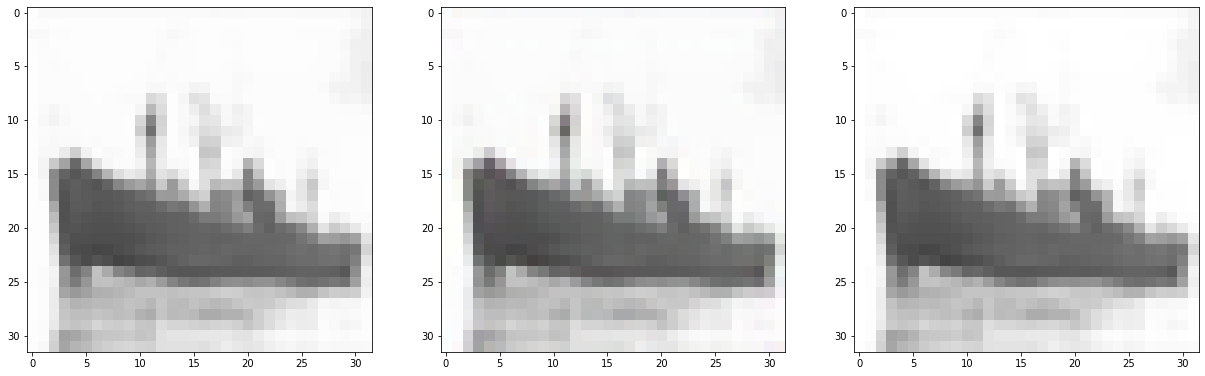

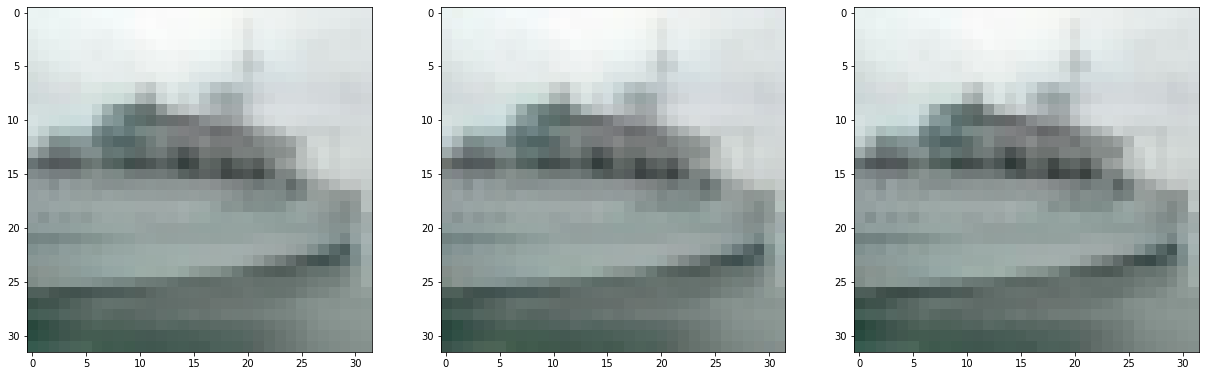

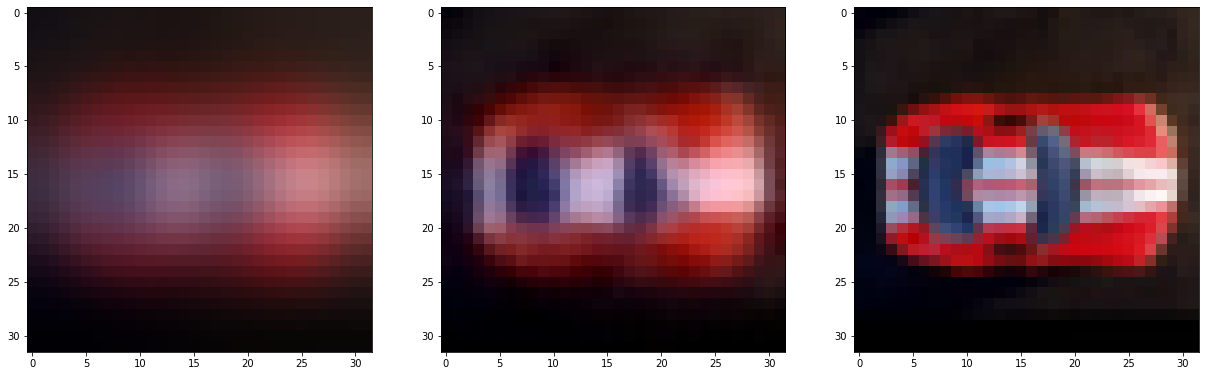

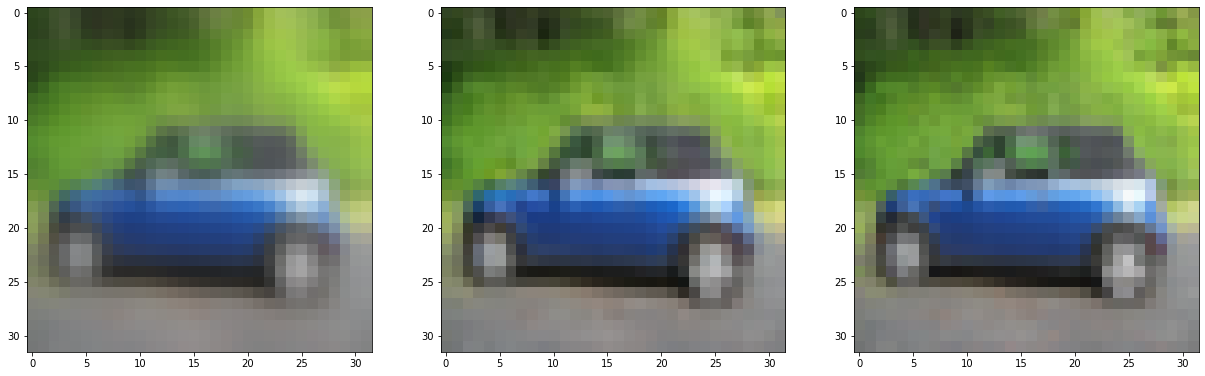

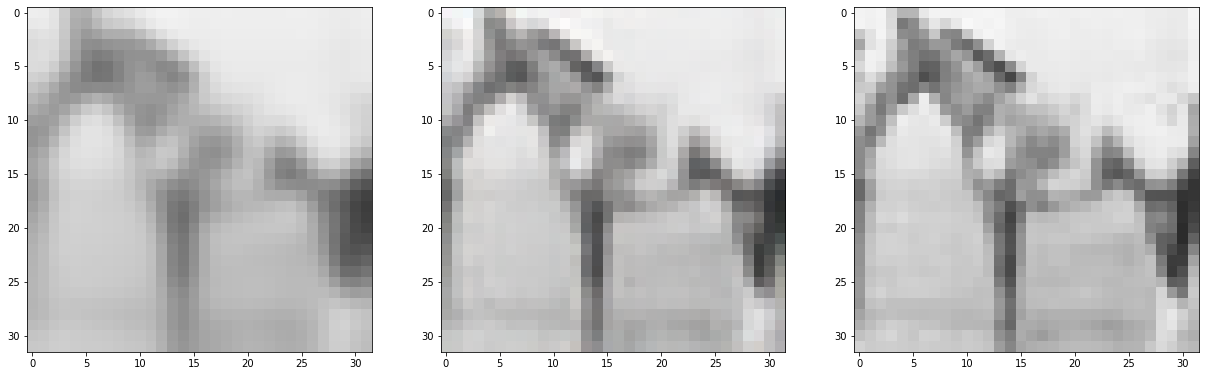

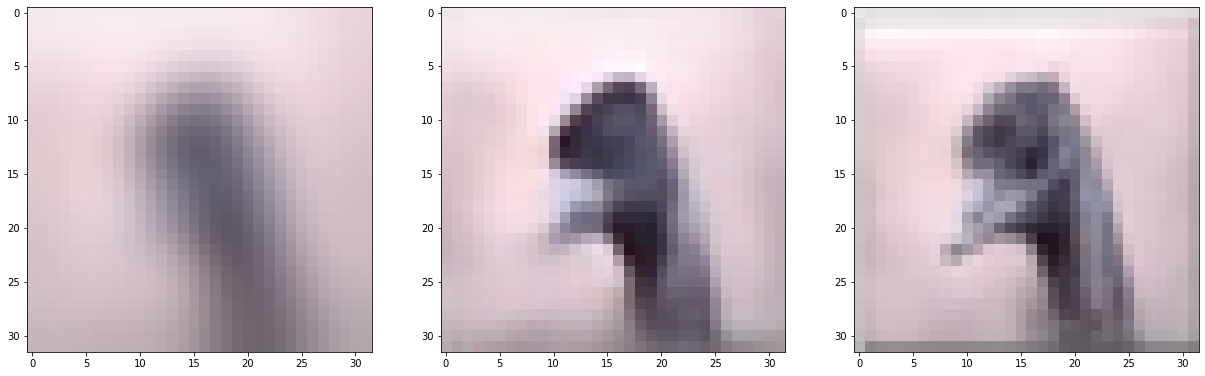

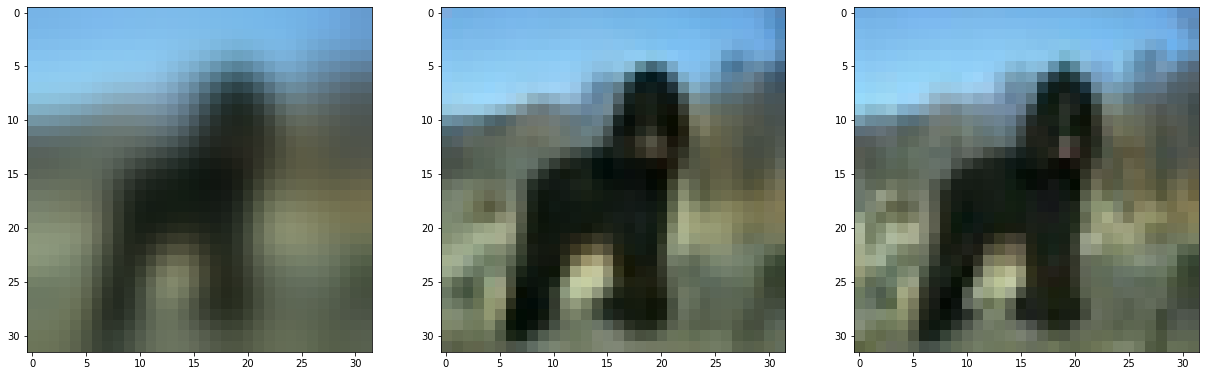

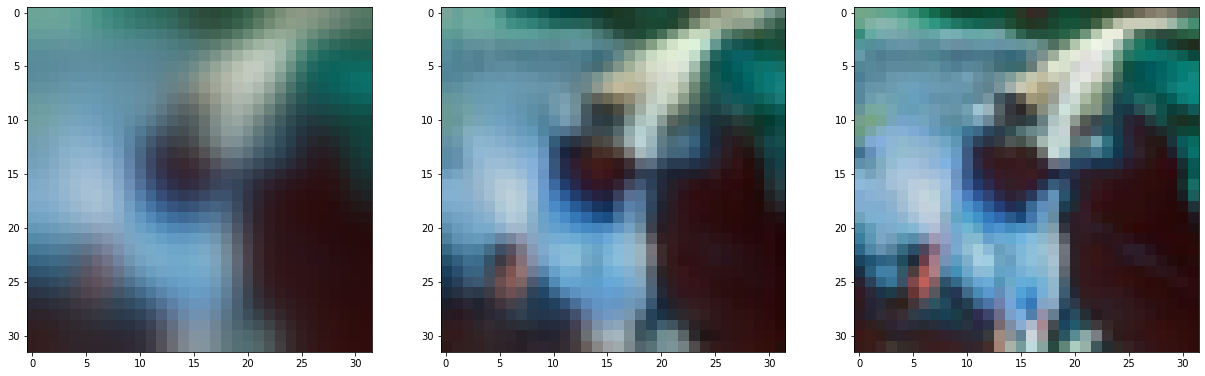

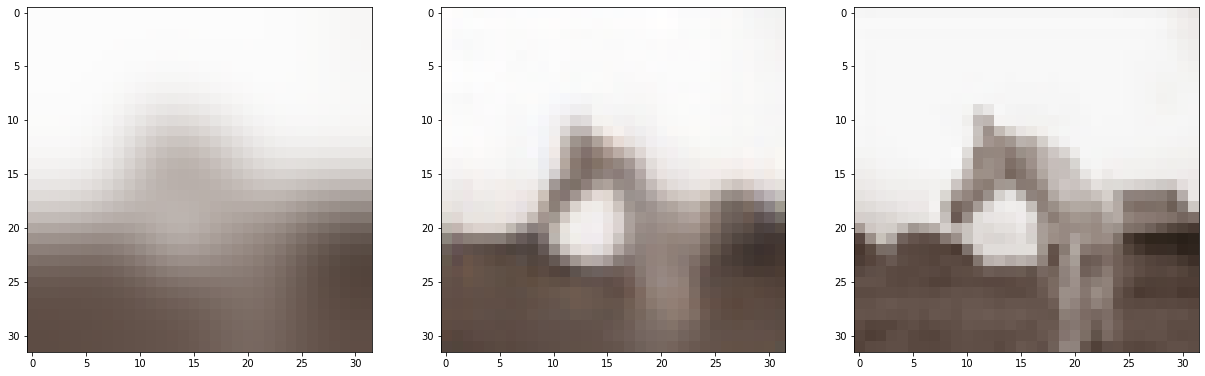

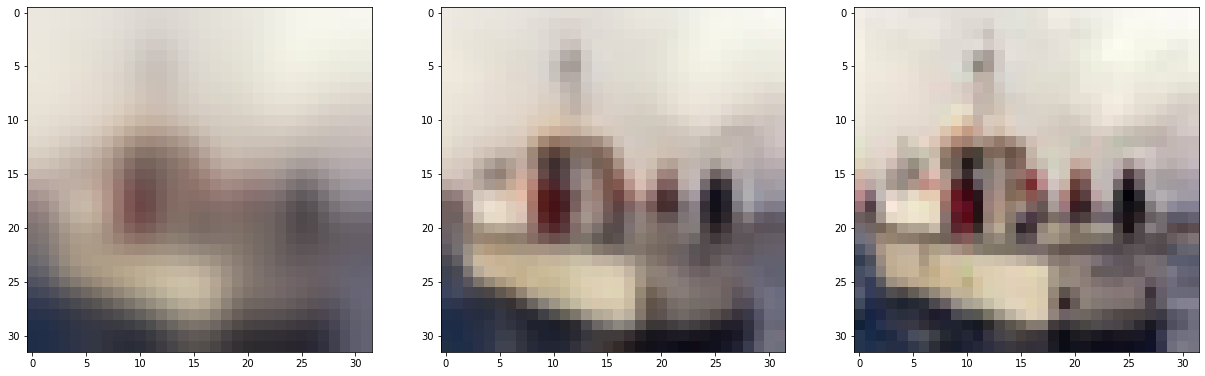

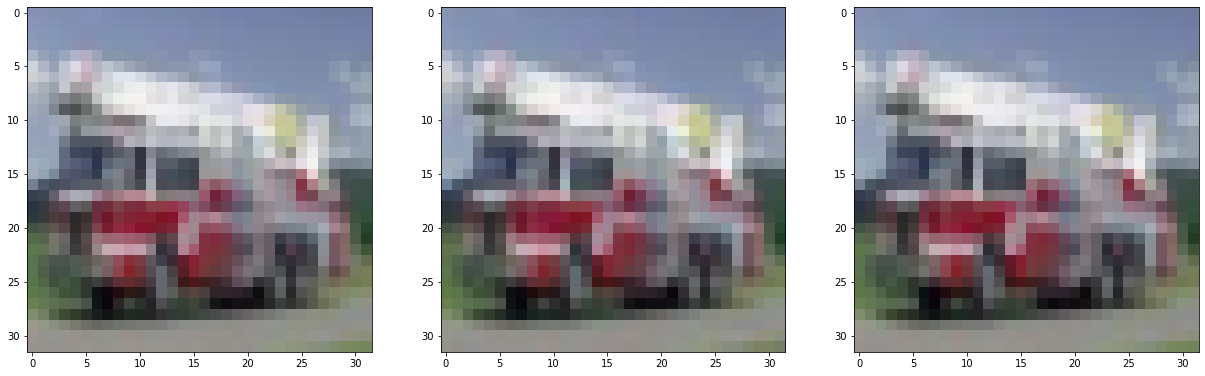

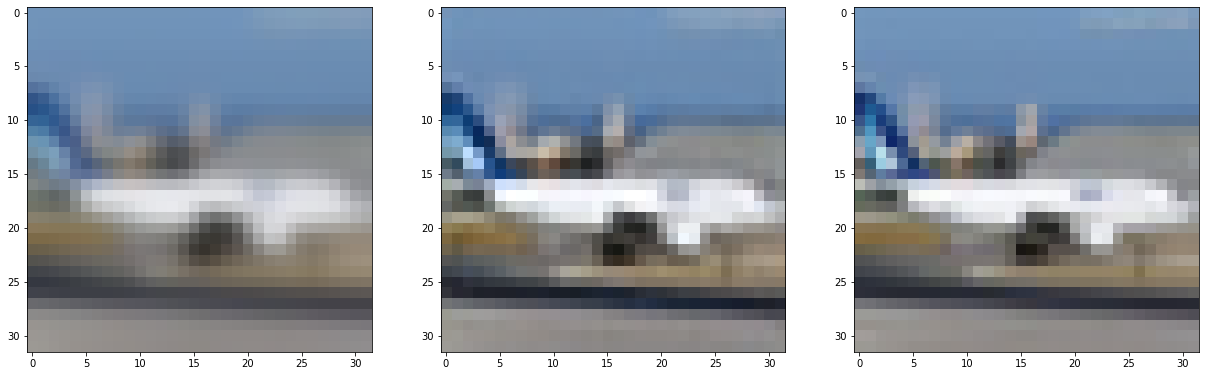

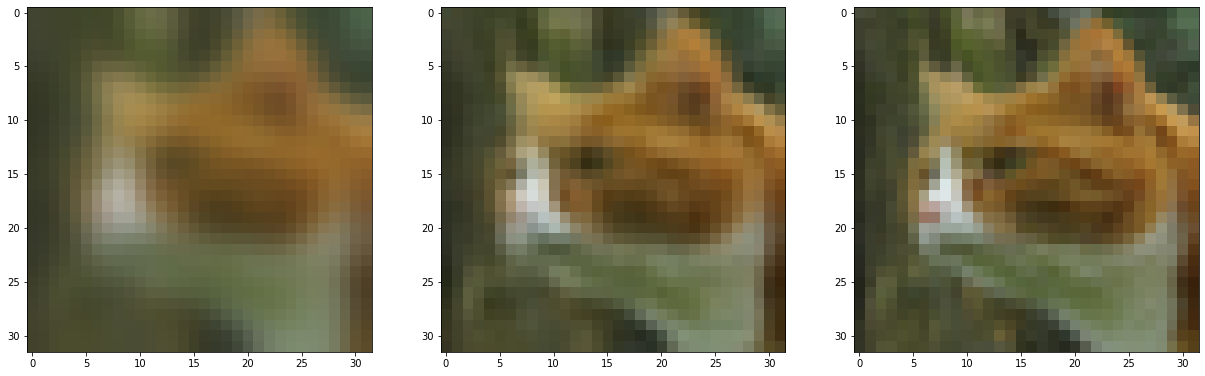

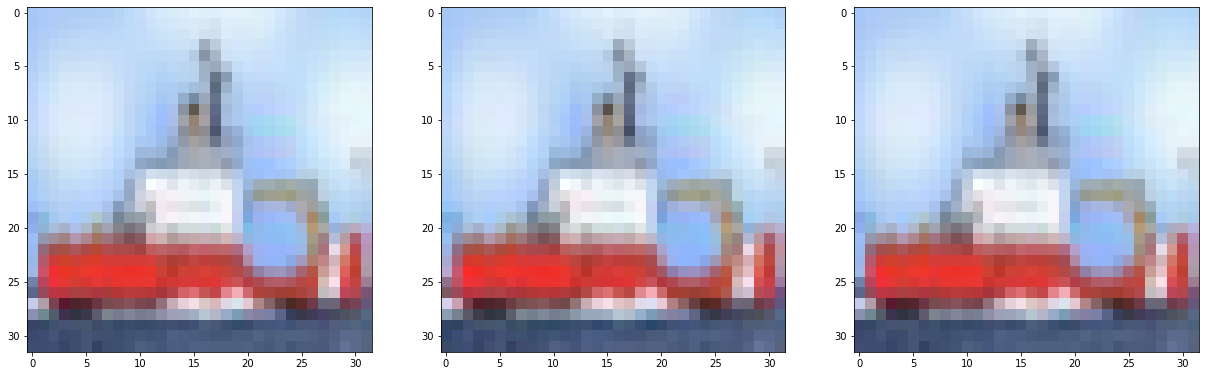

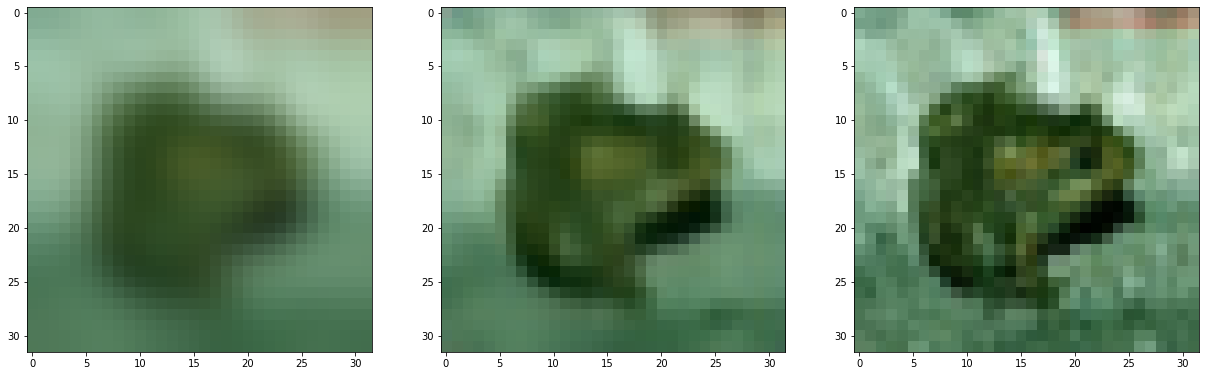

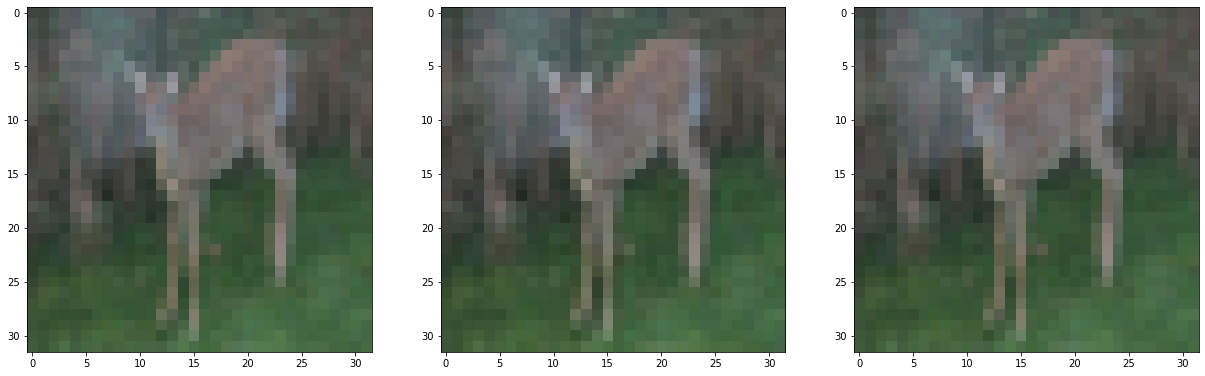

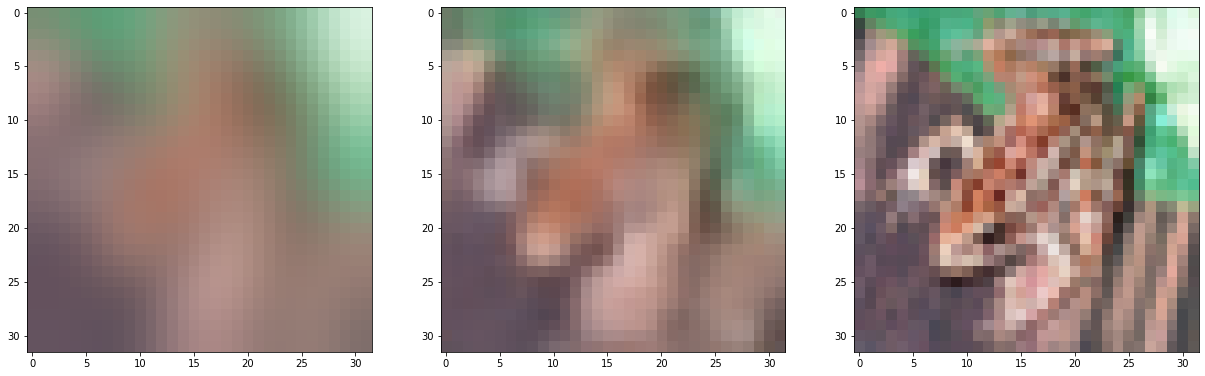

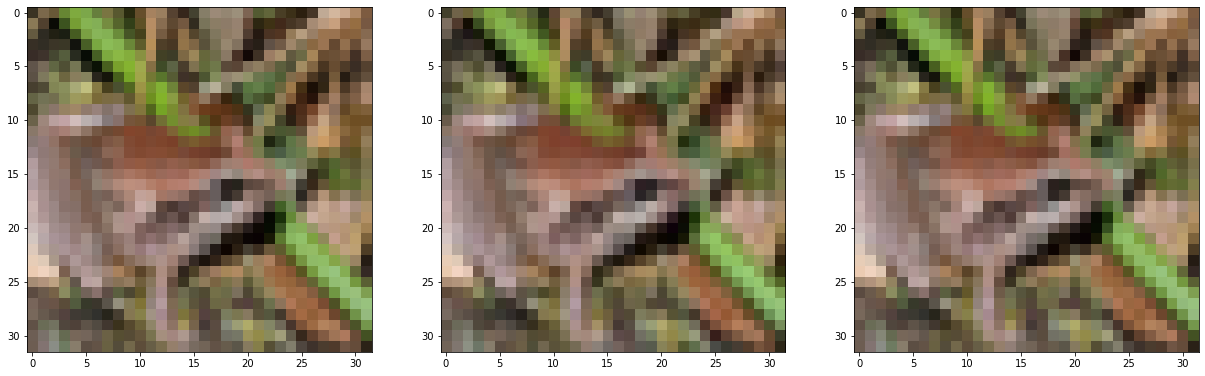

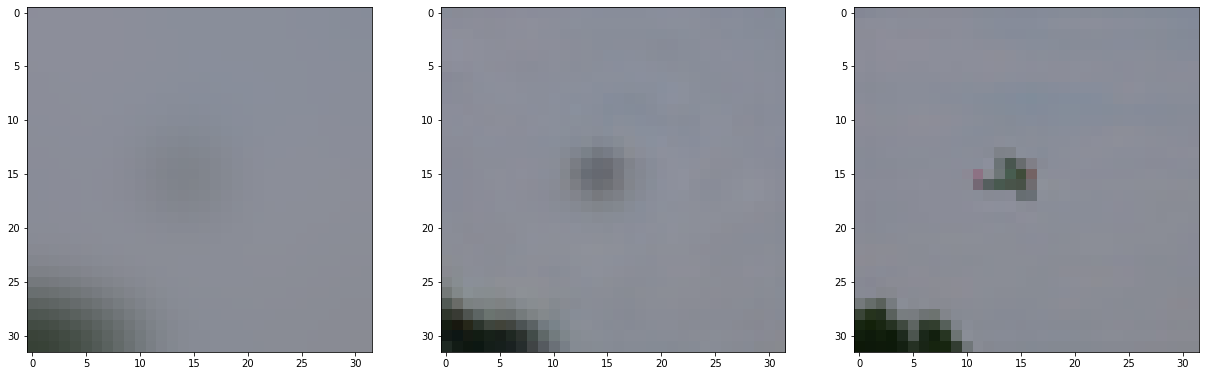

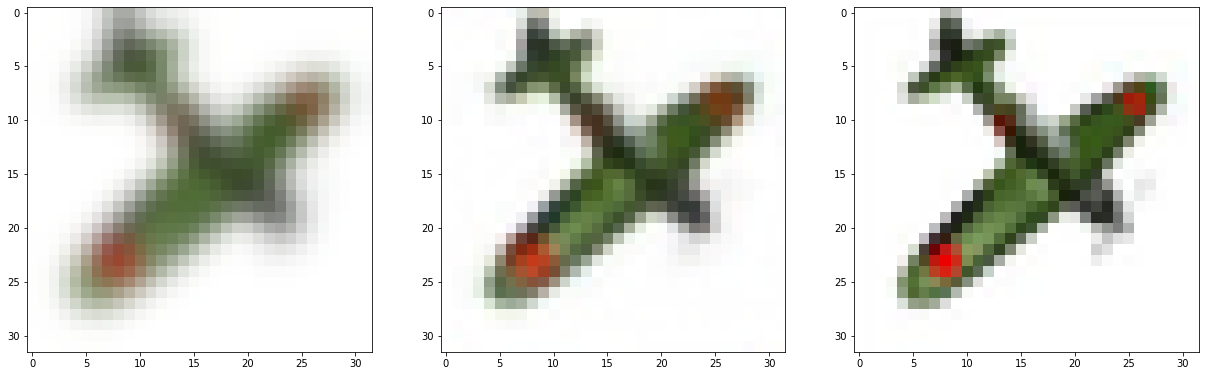

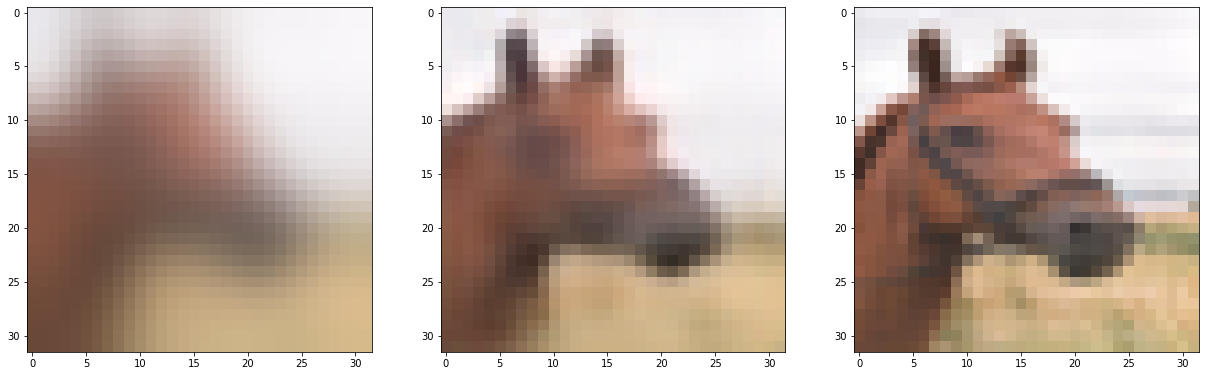

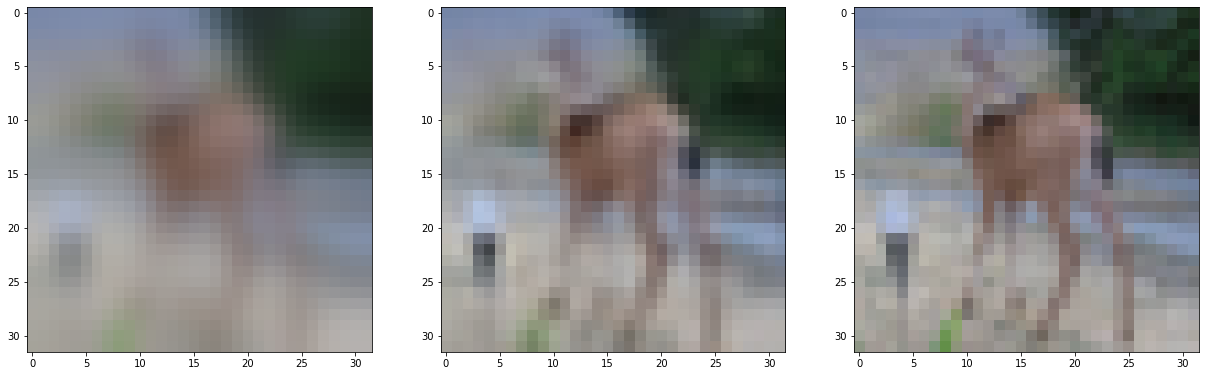

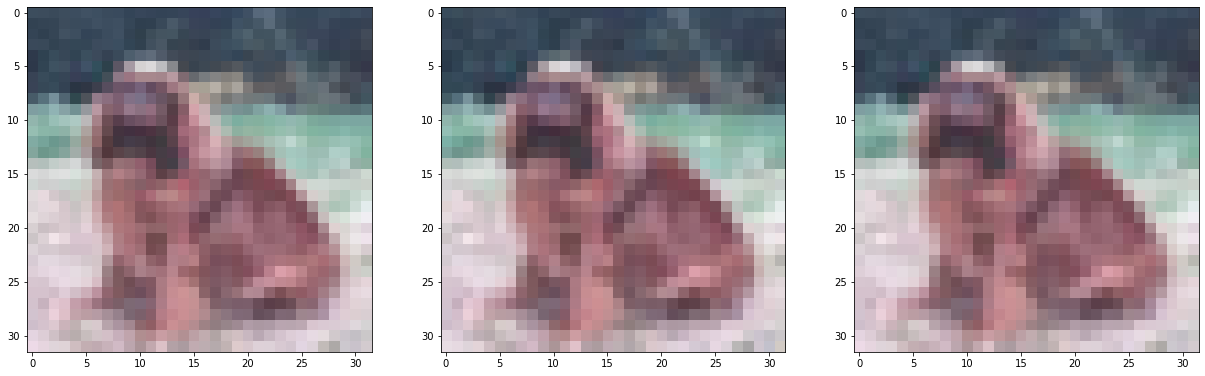

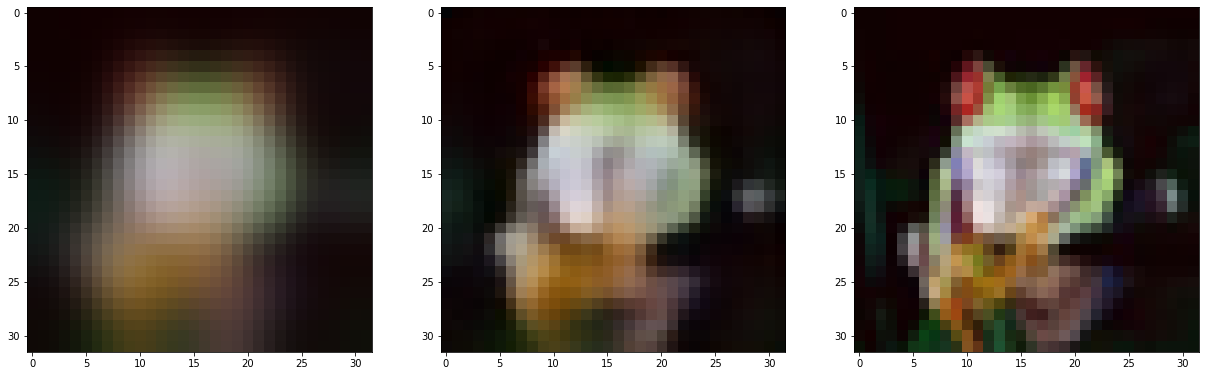

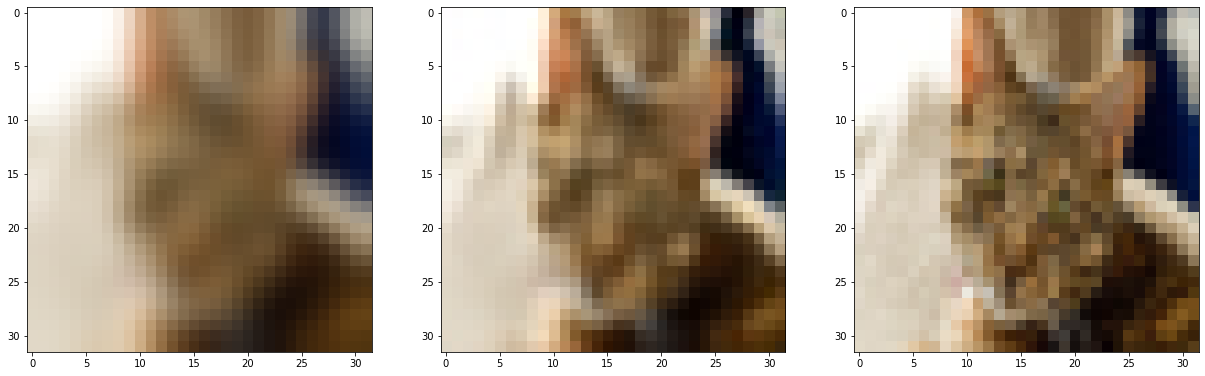

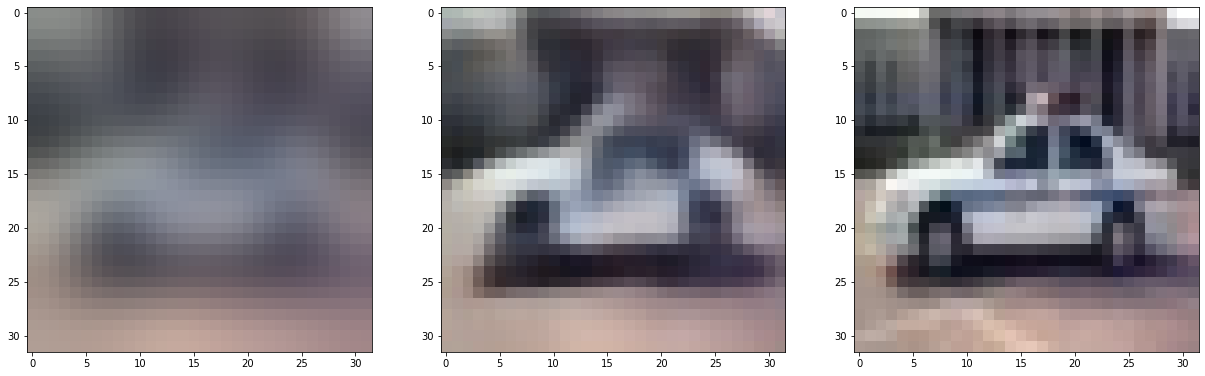

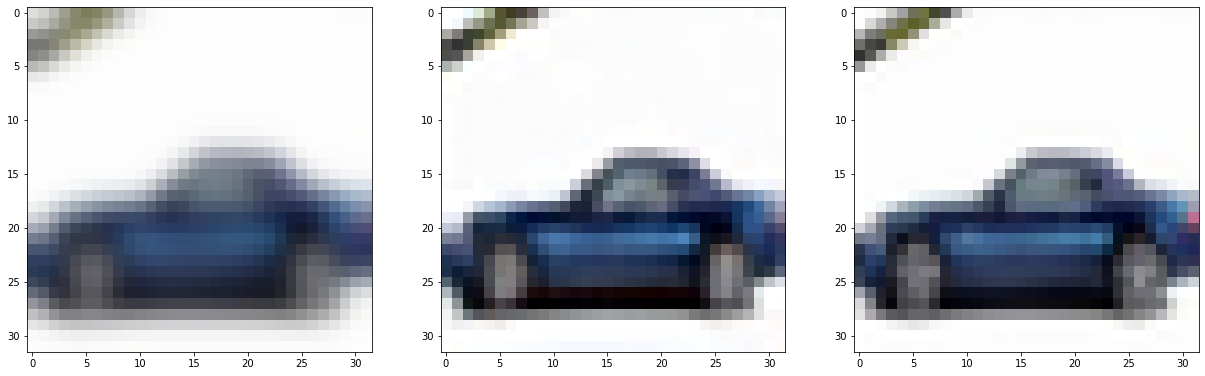

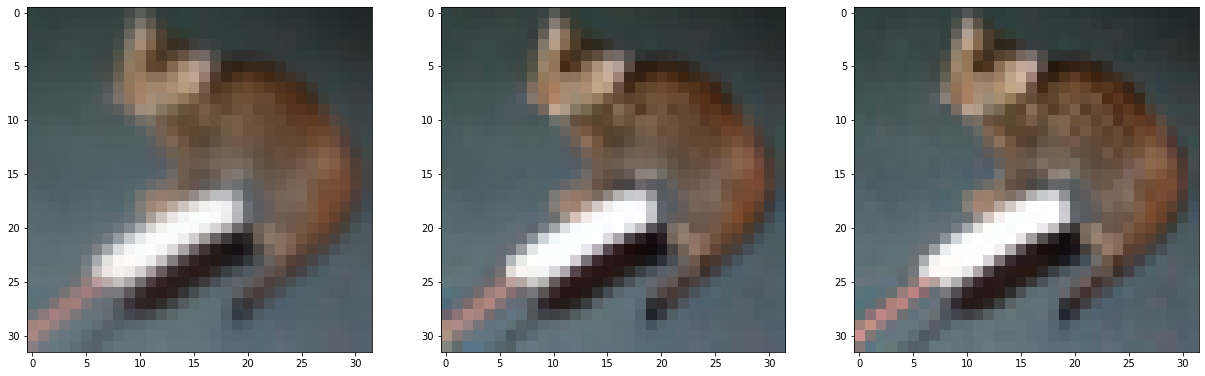

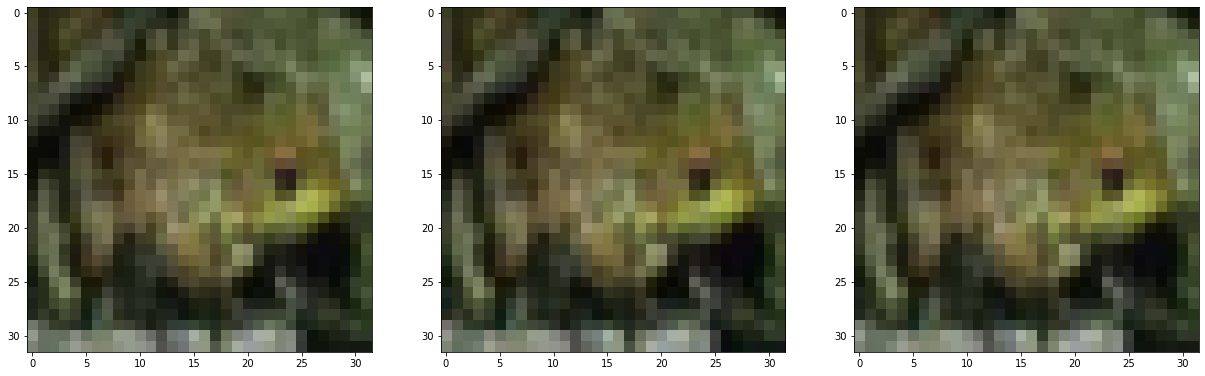

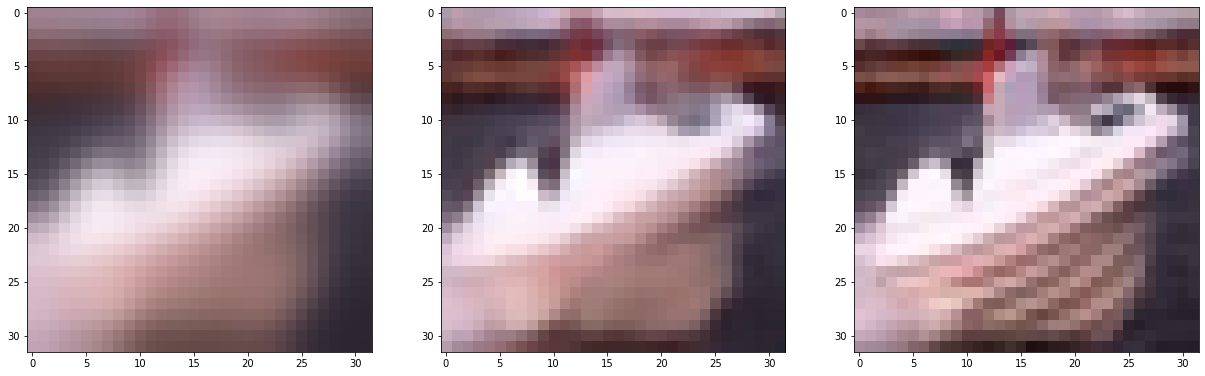

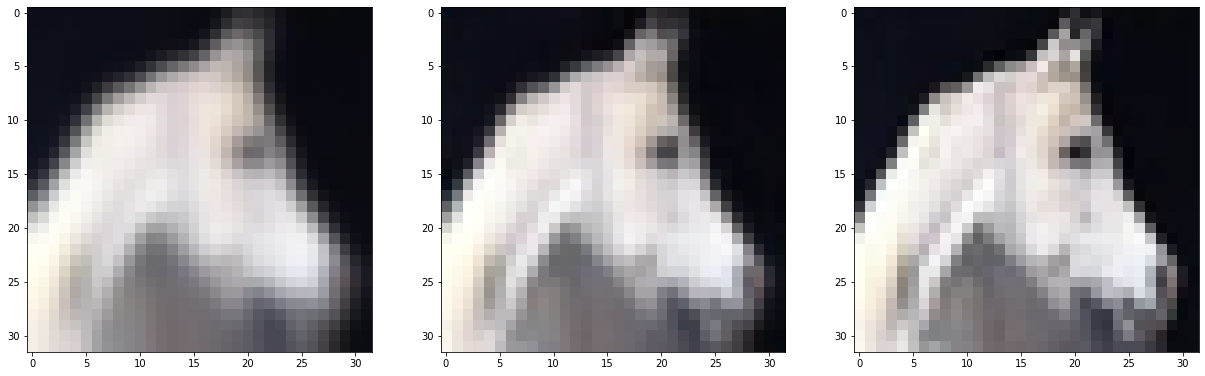

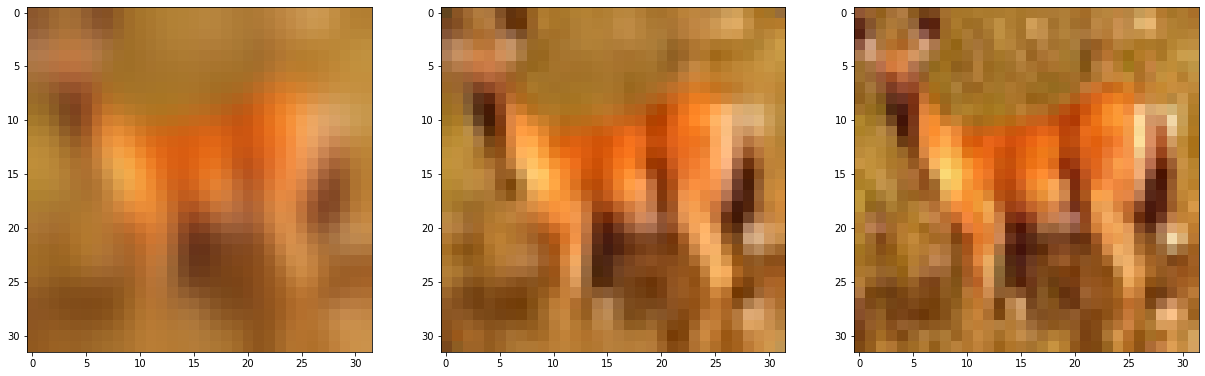

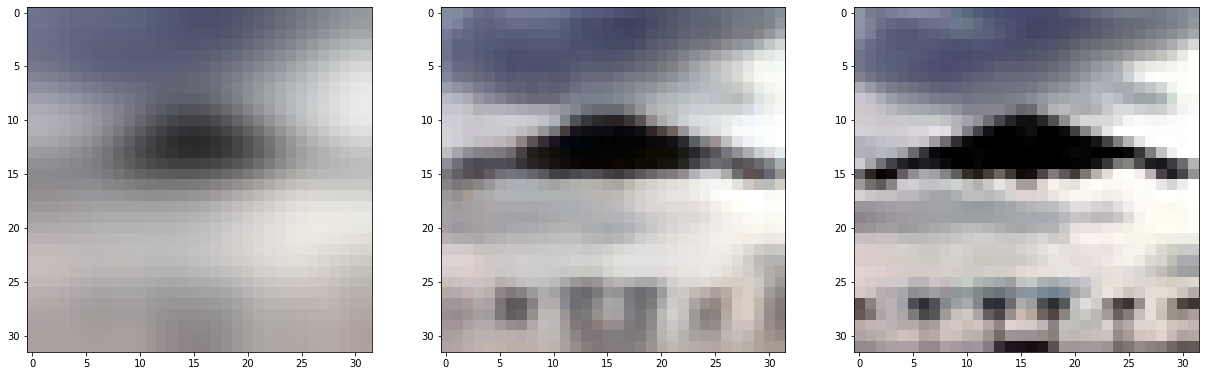

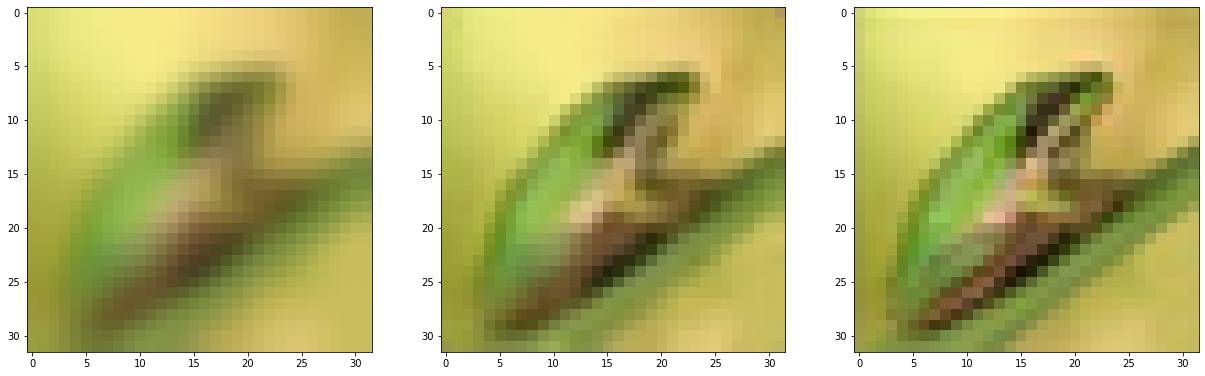

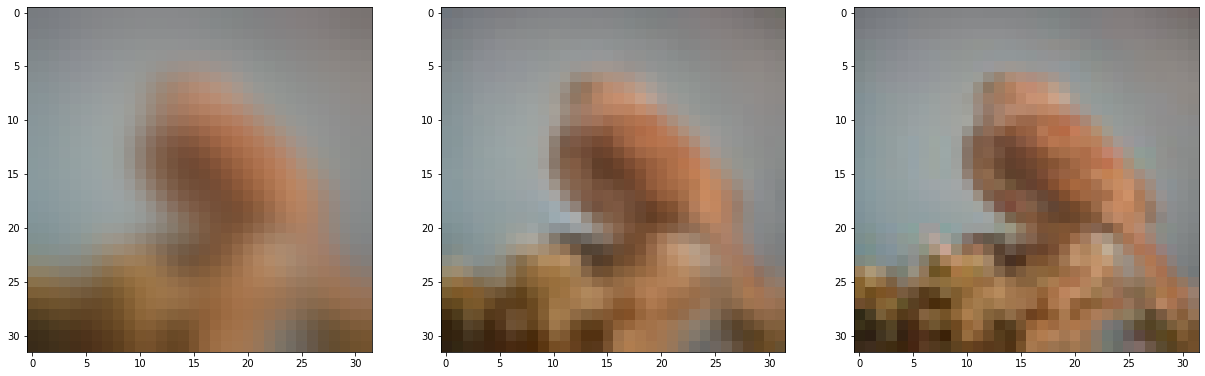

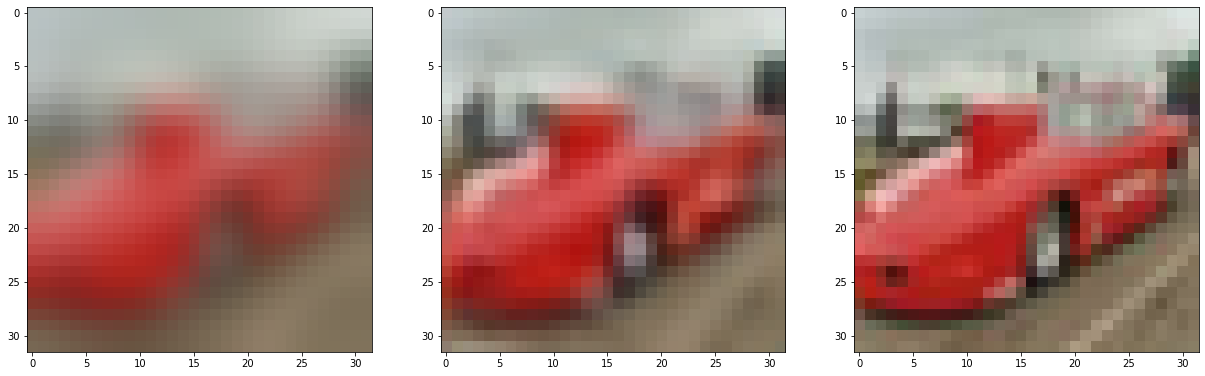

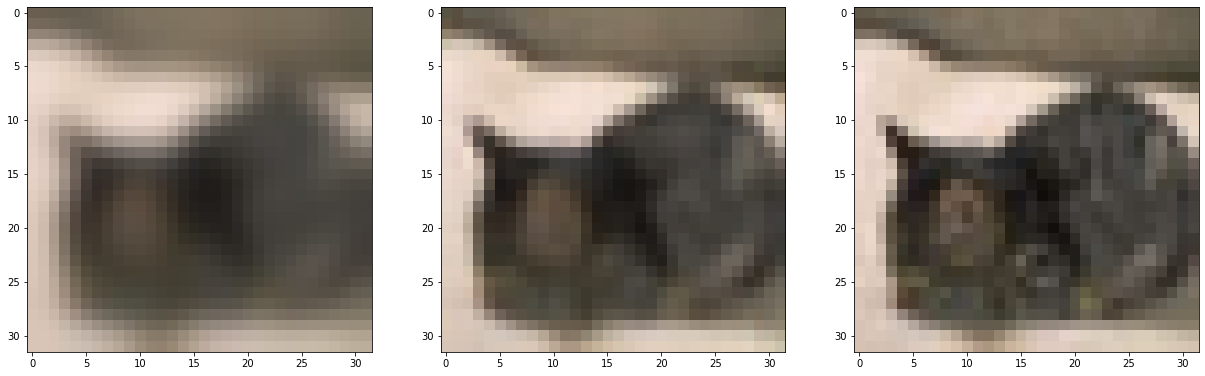

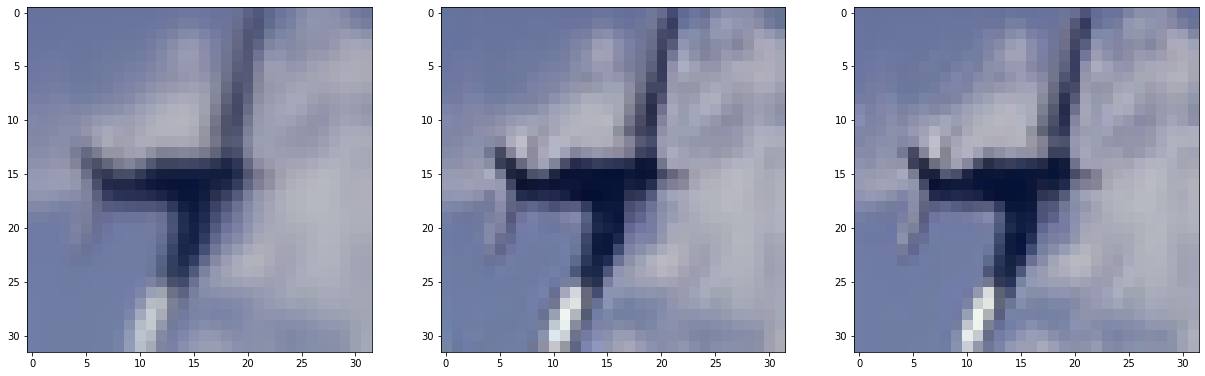

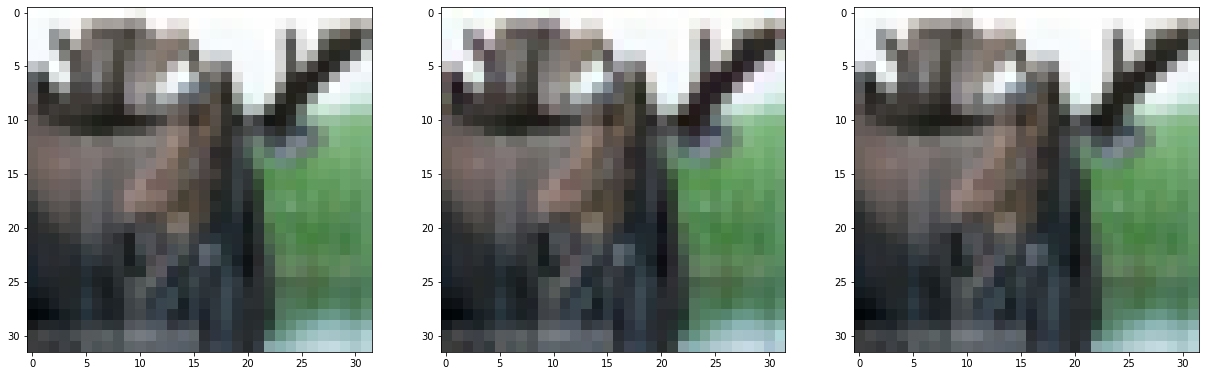

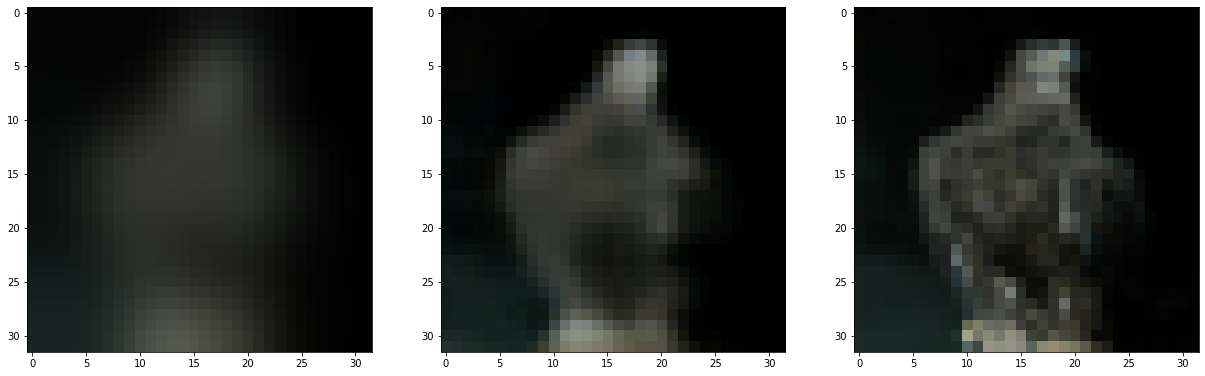

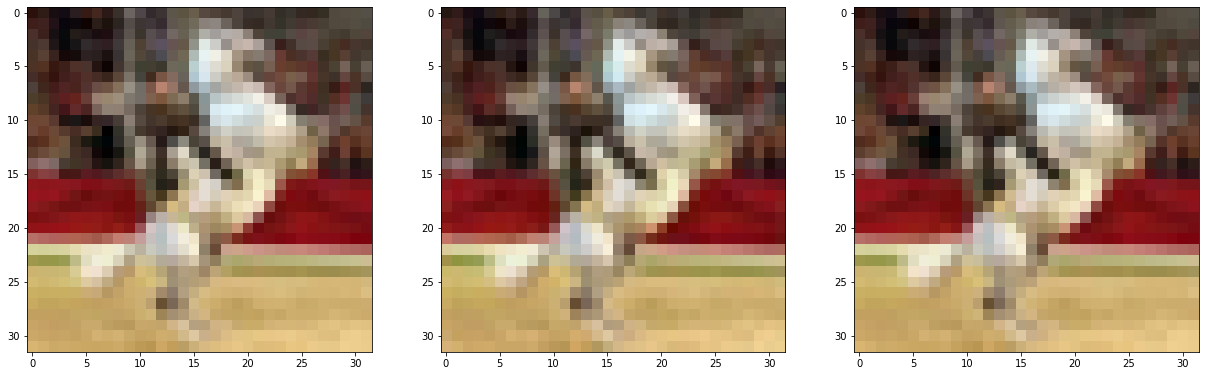

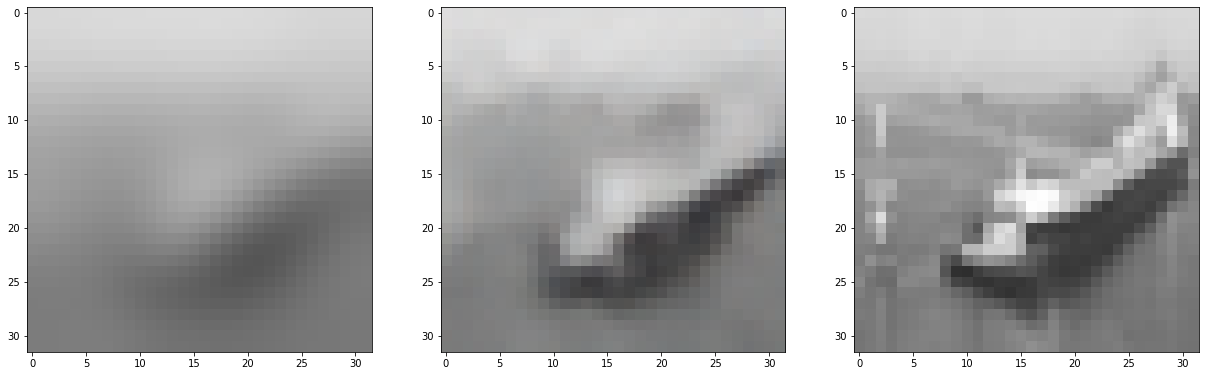

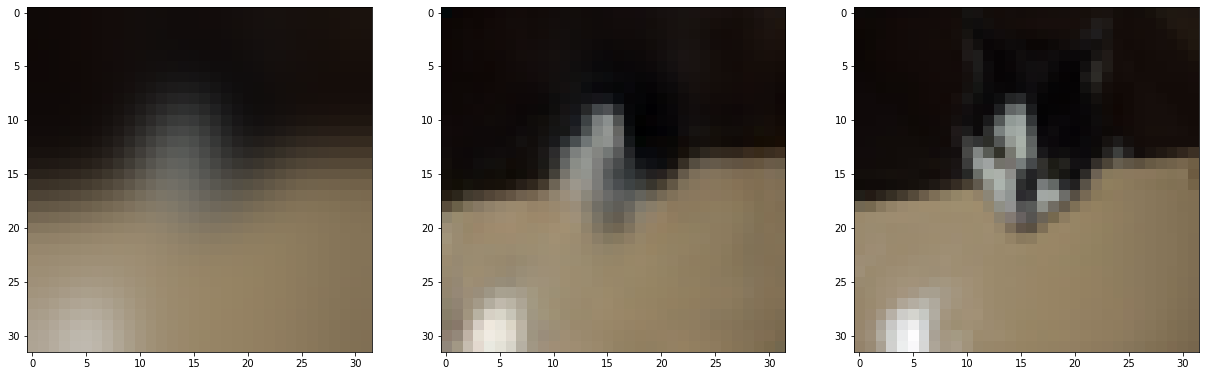

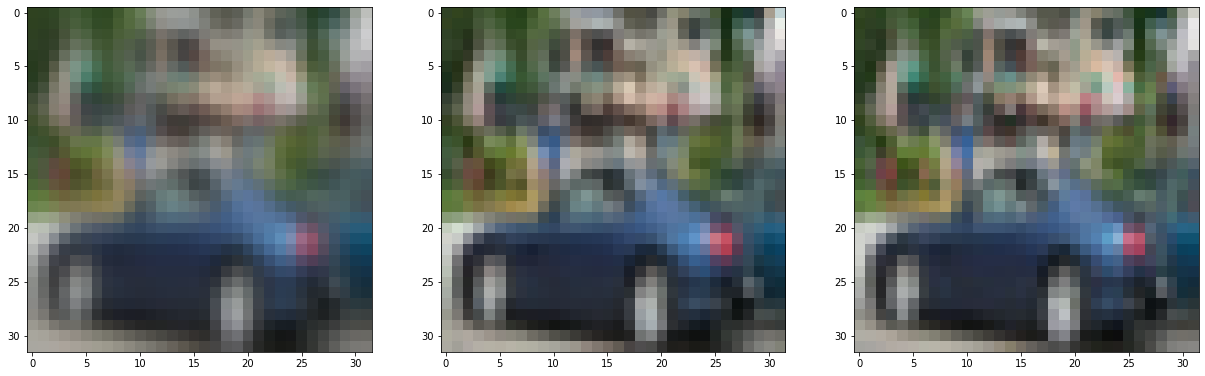

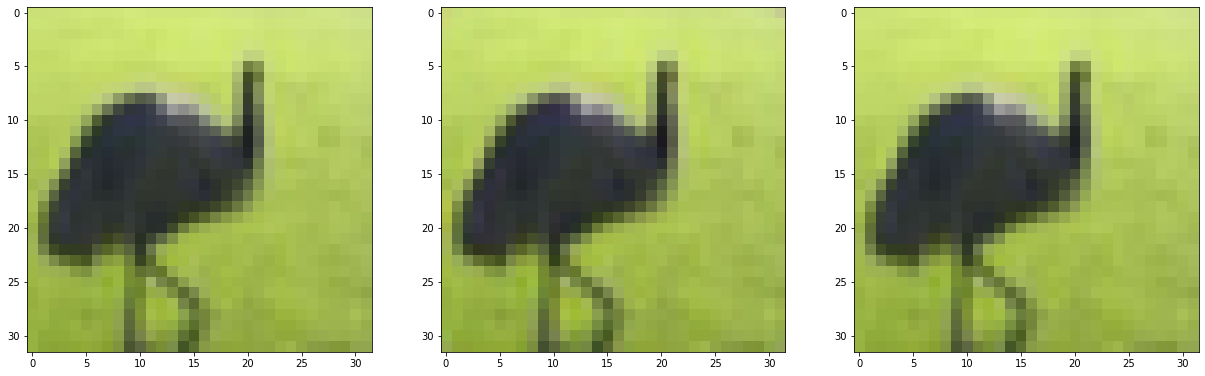

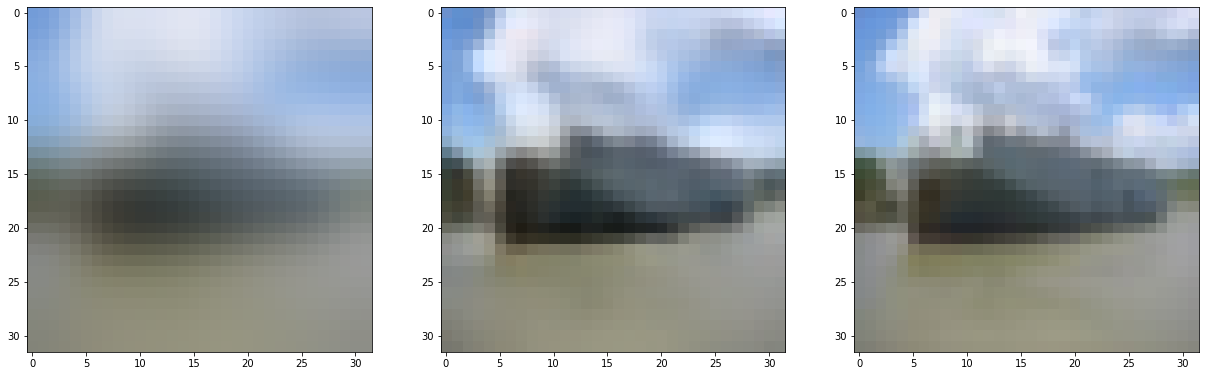

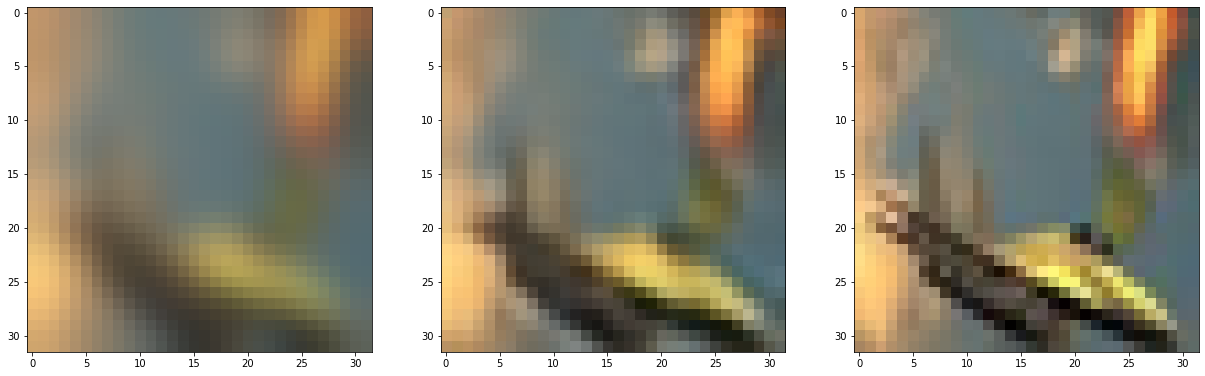

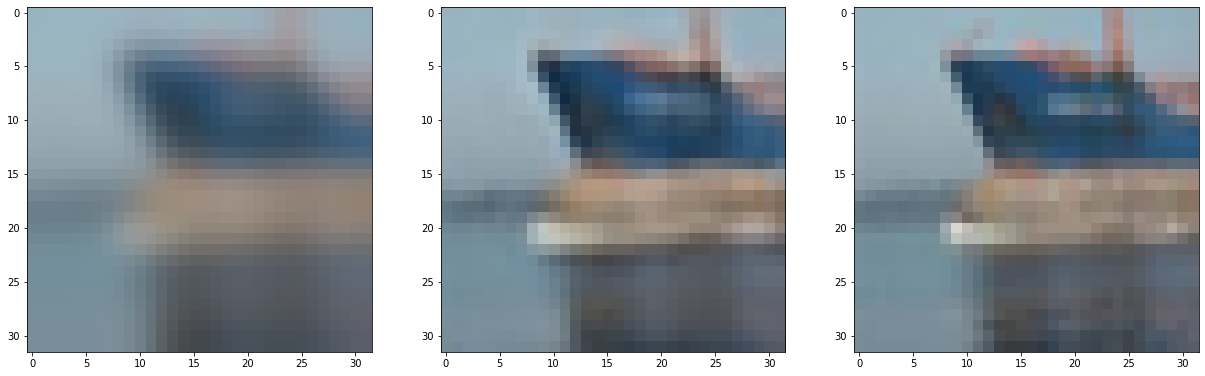

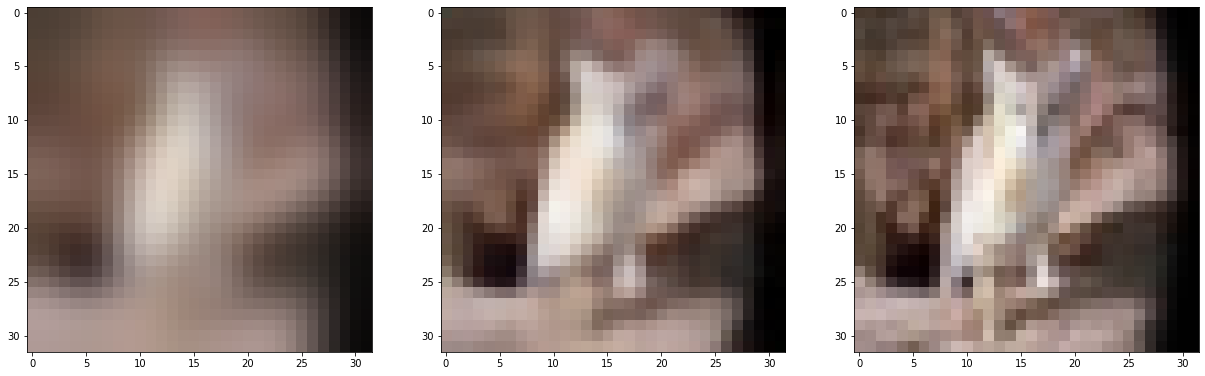

In [ ]:
## VISUALIZE SOME IMAGES ##
image_result = load_data_test(test_mode = 'batch' , batch_size = batch_size, workers = 1, model_dir = save_dir, seed = seed, n_batch = 4)

NOTE: each of the authors *equally* contributes to the whole project. Indeed we shared and discussed every idea and decision. For this reason, we decided not to introduce a section to specify how each of authors contributes to the entire project. 